# CRM Data Analyst Case | IFOOD

# Data Advanced Analytics

In [1]:
# Descrever aqqui um pouco do racional do case e o approach adotado que vc vai seguir! :3

## Import inicial básico

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as metrics_sk
%matplotlib inline
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', None)

In [3]:
os.chdir("C:/Users/Benedito/Desktop/propensity_score/")

## 1) Leitura e inspeção da base de estudo

In [4]:
# Lendo o dataframe
csv_file = 'ml_project1_data.csv'
df       = pd.read_csv('./' + csv_file)

In [5]:
# Informações básicas do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
# No dataframe ID, Z_CostContact, Z_Revenue não irão ser utilizadas na modelagem, sendo que o ID - no de identificação do cliente,
# Z_CostContact e Z_Revenue serão usadas nas análises estratégicas pois podem ser consideradas não como features mas como targets
# de CRM, Year_Birth de uma estimativa da idade
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [7]:
# Inspeção se existem missing values: tem 24 missing values na variável Income
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [8]:
# Como a valumetria de clientes sem a informação de renda corresponde a ~1% resolvi removê-los (outra abordagem seria imputação
# pela média ou usar knn com algumas variáveis da base)
df = df.dropna(axis = 0)
df.shape

(2216, 29)

## 2) Criação de novas features para análise

In [9]:
# Aqui irei criar duas variáveis Tenure - tempo de relacionamento do cliente com a empresa (meses), e Age - idade do cliente 
# (em anos), vou supor que a amostra seja de clientes que atenderam uma campanha ficticia de janeiro de 2021

In [10]:
# Criando a variável AGE
df['Age'] = 2021 - df['Year_Birth']

In [11]:
# Criando a variável Tenure  df.date1)/np.timedelta64(1, 'M'))
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer) 

In [12]:
df['Tenure'] = (pd.to_datetime('2021-01-01') - df.Dt_Customer)/np.timedelta64(1,'M')
df['Tenure'] = df.Tenure.astype(int) # Tomando a parte inteira

In [13]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Tenure
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,64,99
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,67,81
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,56,88
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,37,82
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,40,83


In [14]:
# Permancer apenas com as colunas para as análises de modelagem (as outras de estratégia depois de usar o modelo e antes de 
# usar o modelo)
columns_2_remove = ['Year_Birth','Dt_Customer','Z_CostContact','Z_Revenue']
df_2 = df.drop(columns_2_remove, axis=1)

In [15]:
df_2.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Tenure
0,5524,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,64,99
1,2174,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,67,81
2,4141,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,56,88
3,6182,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,37,82
4,5324,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,40,83


In [16]:
# Vou ordenar as variáveis por macro características
variables = ['ID',
             
             # Caracteristicas do cliente (inc demografia)             
             'Age','Education','Marital_Status','Income','Kidhome','Teenhome','Tenure',
             
             # Comportamento em campanhas passadas
             'AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5',
             
             # Informação de atrito com a empresa
             'Complain',
             
             # Comportamento de compras de itens e produtos
             'Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',
             
             # Comportamento sobre a forma de compra do cliente
             'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
            
             # Variável resposta
             'Response'
            ]
df_2 = df_2.reindex(columns = variables)  
df_2.head()

,ID,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Tenure,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Response
0,5524,64,Graduation,Single,58138.0,0,0,99,0,0,0,0,0,0,58,635,88,546,172,88,88,3,8,10,4,1
1,2174,67,Graduation,Single,46344.0,1,1,81,0,0,0,0,0,0,38,11,1,6,2,1,6,2,1,1,2,0
2,4141,56,Graduation,Together,71613.0,0,0,88,0,0,0,0,0,0,26,426,49,127,111,21,42,1,8,2,10,0
3,6182,37,Graduation,Together,26646.0,1,0,82,0,0,0,0,0,0,26,11,4,20,10,3,5,2,2,0,4,0
4,5324,40,PhD,Married,58293.0,1,0,83,0,0,0,0,0,0,94,173,43,118,46,27,15,5,5,3,6,0


## 3) EDA

## 3.1) Variáveis Quantitativas: análises univariada e bivariada

In [17]:
vars_num = ['Age','Income','Kidhome','Teenhome',
            'Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',
            'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','Response']

In [18]:
df_aux = df_2[vars_num]

In [19]:
# Breve sumário estatístico das variáveis
df_aux.describe()

# prestar atenção aos outliers da idade e da renda 128 e $666.666

,Age,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Response
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52.179603,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,0.150271
std,11.985554,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,0.357417
min,25.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,0.000000
50%,51.000000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,0.000000
75%,62.000000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,0.000000
max,128.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,1.000000


In [20]:
# Setando o tamanho das fontes
sns.set(font_scale = 1.1)
sns.set_style('white')

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='Age'>

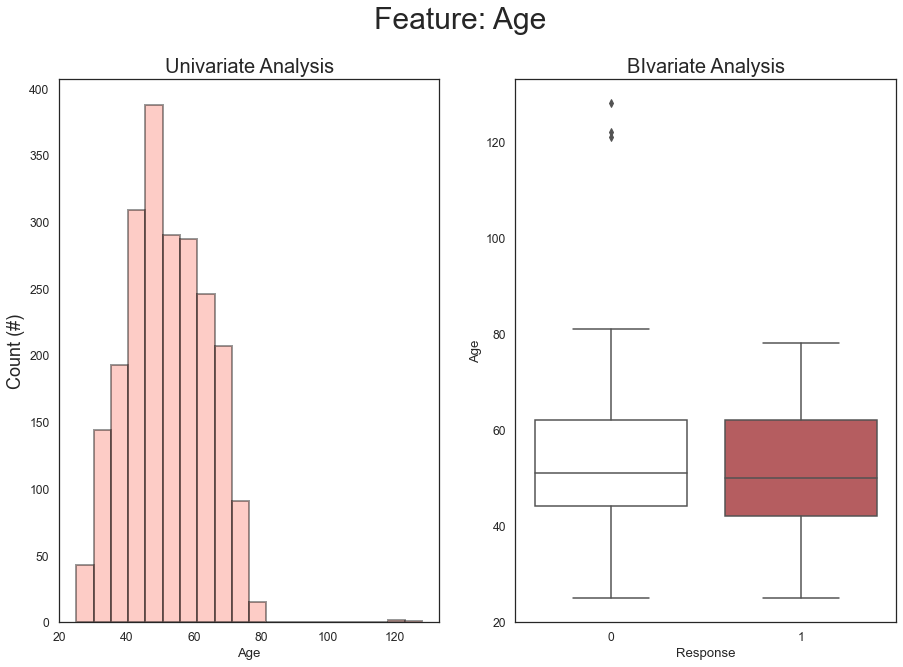

In [21]:
# Variável: Age
plt.figure(figsize = (15,10))
plt.suptitle('Feature: Age \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['Age'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'Age', data = df_aux,palette=my_pal)

# OBS: Outliers na idade > 80 anos

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='Income'>

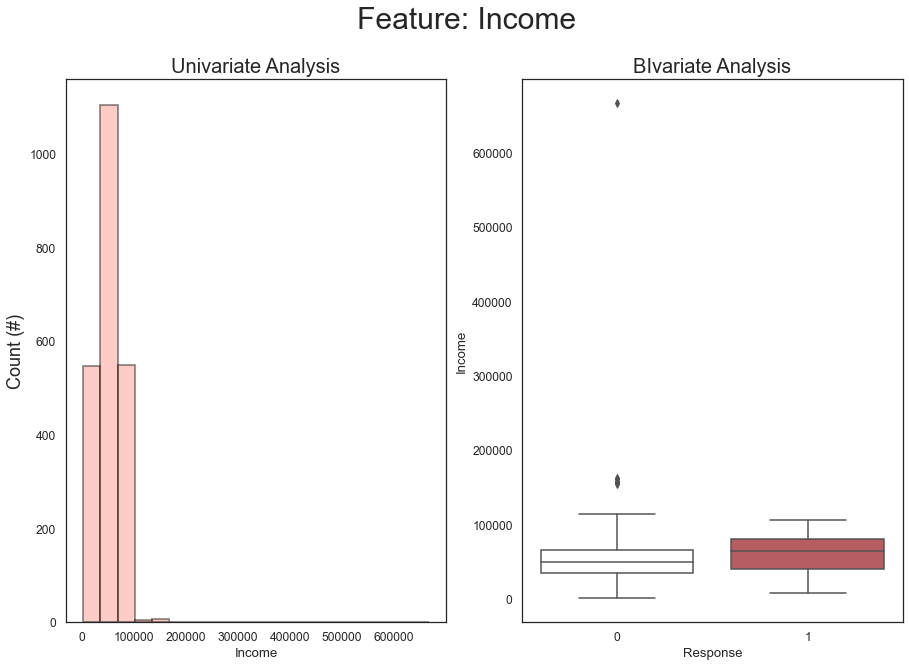

In [22]:
# Variável: Income
plt.figure(figsize = (15,10))
plt.suptitle('Feature: Income \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['Income'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'Income', data = df_aux,palette=my_pal)

# OBS: outliers > $200.000

<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='Kidhome'>

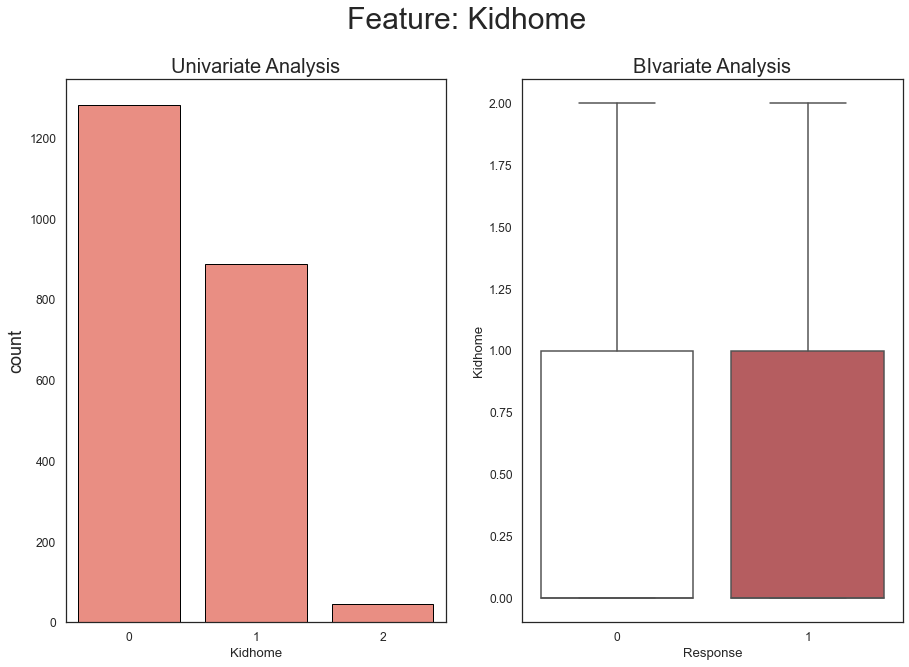

In [23]:
# Variável: Kidhome
plt.figure(figsize = (15,10))
plt.suptitle('Feature: Kidhome \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = "Kidhome", data=df_aux, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'Kidhome', data = df_aux,palette=my_pal)

# OBS: NA

<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='Teenhome'>

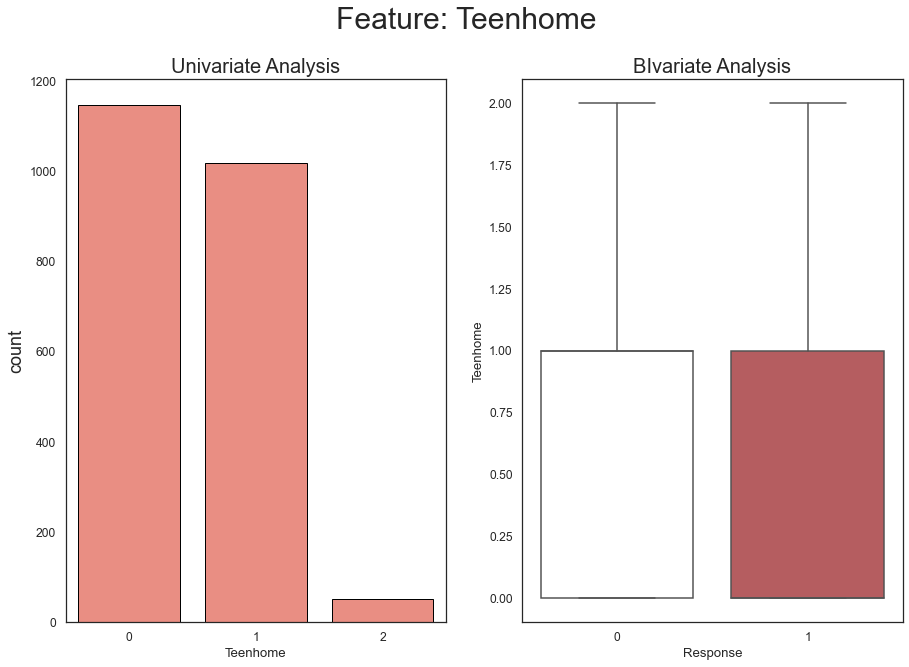

In [24]:
# Variável: Teenhome
plt.figure(figsize = (15,10))
plt.suptitle('Feature: Teenhome \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = "Teenhome", data=df_aux, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'Teenhome', data = df_aux,palette=my_pal)

# OBS: NA

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='Recency'>

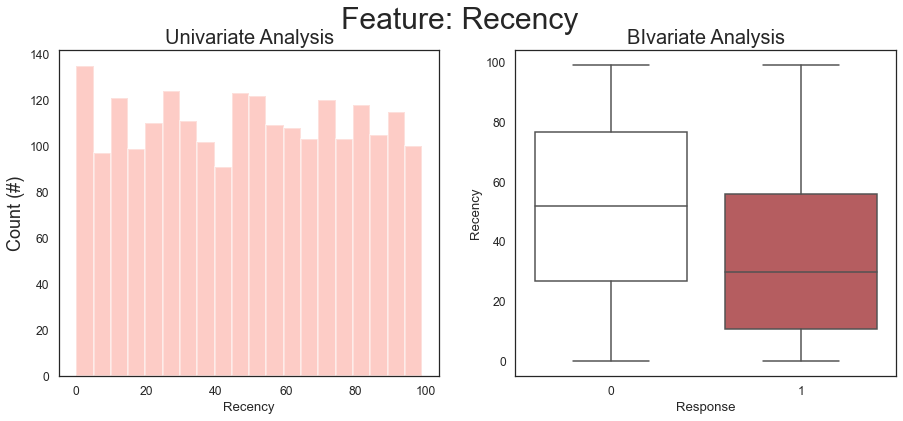

In [119]:
# Variável: Recency
plt.figure(figsize = (15,6))
plt.suptitle('Feature: Recency \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['Recency'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "white", linewidth=2))


plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'Recency', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='MntWines'>

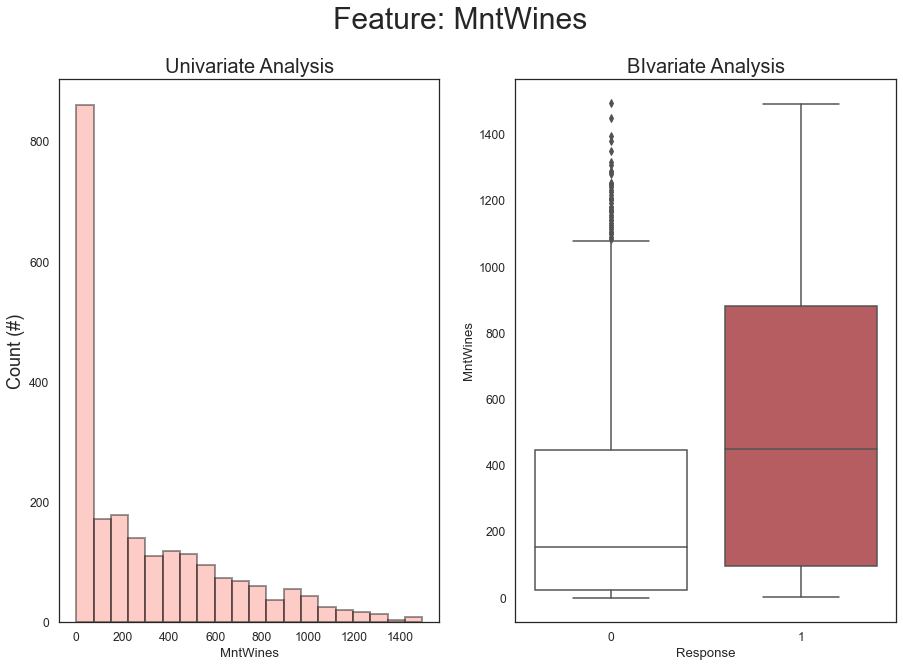

In [26]:
# Variável: MntWines
plt.figure(figsize = (15,10))
plt.suptitle('Feature: MntWines \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['MntWines'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'MntWines', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='MntFruits'>

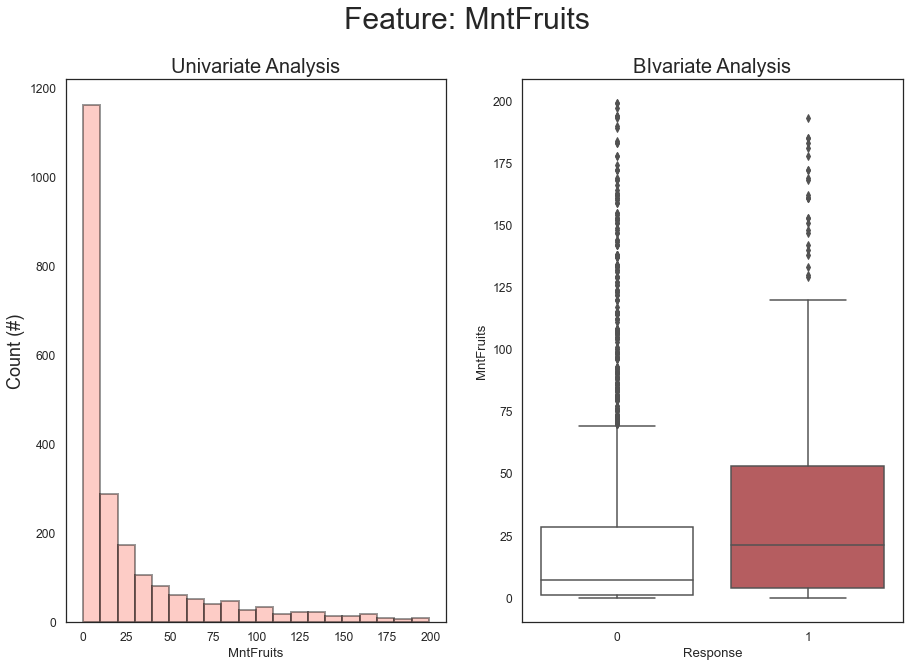

In [27]:
# Variável: MntFruits
plt.figure(figsize = (15,10))
plt.suptitle('Feature: MntFruits \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['MntFruits'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'MntFruits', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='MntMeatProducts'>

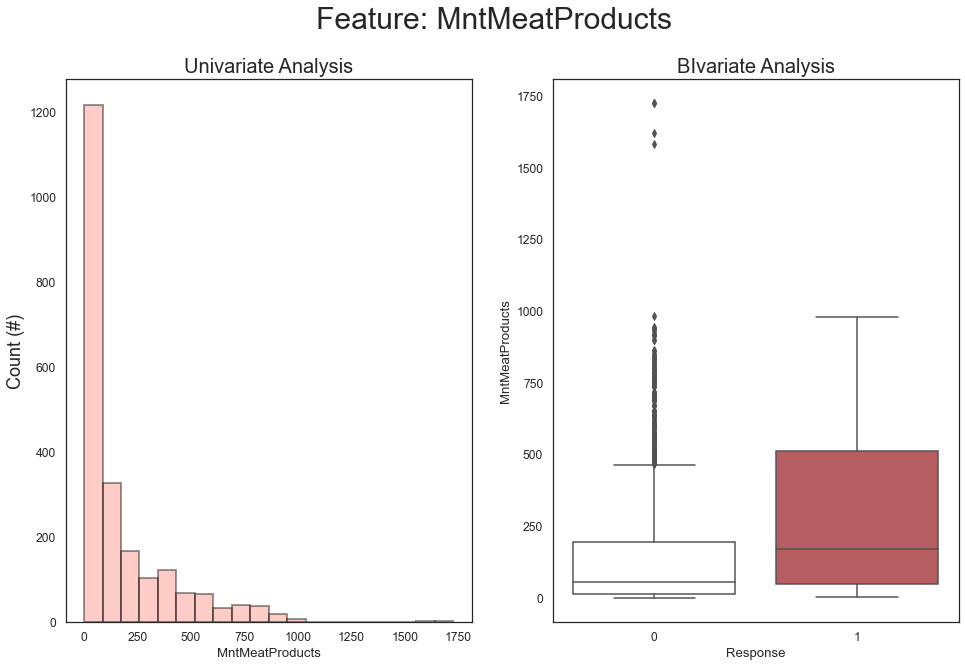

In [28]:
# Variável: MntMeatProducts
plt.figure(figsize = (16,10))
plt.suptitle('Feature: MntMeatProducts \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['MntMeatProducts'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'MntMeatProducts', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='MntFishProducts'>

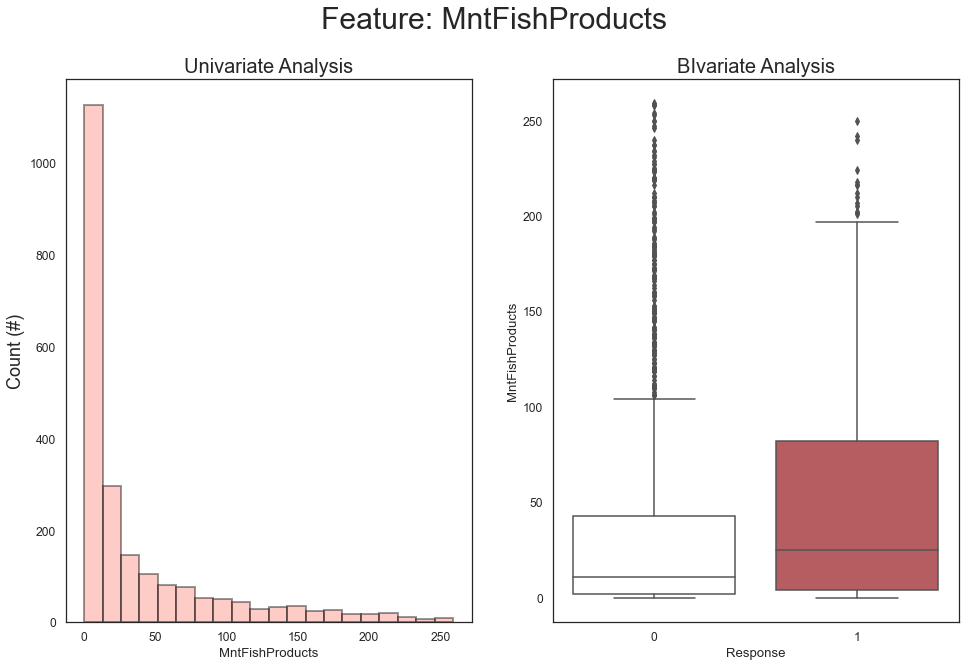

In [29]:
# Variável: MntFishProducts
plt.figure(figsize = (16,10))
plt.suptitle('Feature: MntFishProducts \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['MntFishProducts'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'MntFishProducts', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='MntSweetProducts'>

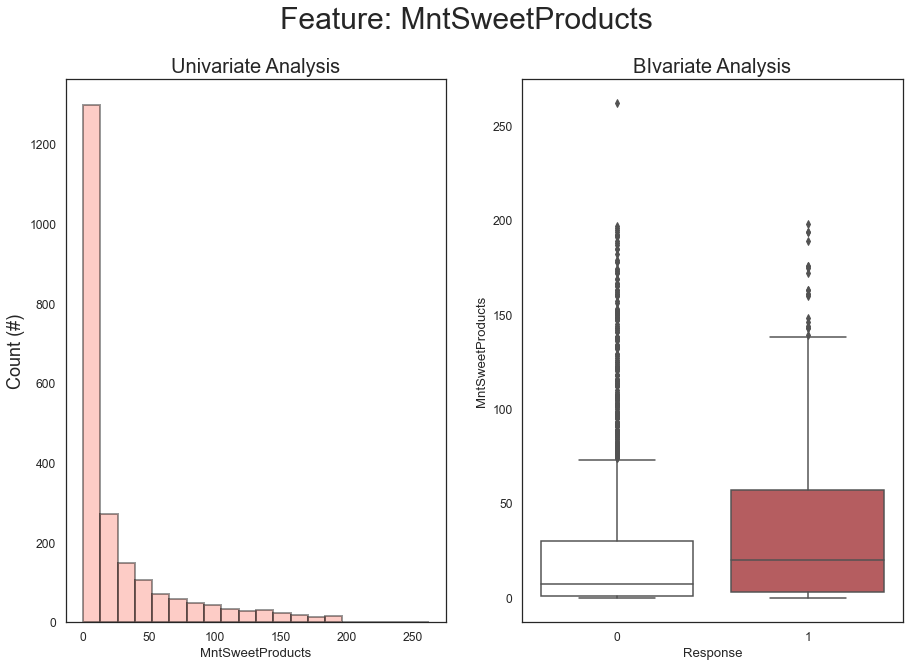

In [30]:
# Variável: MntSweetProducts
plt.figure(figsize = (15,10))
plt.suptitle('Feature: MntSweetProducts \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['MntSweetProducts'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'MntSweetProducts', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='MntGoldProds'>

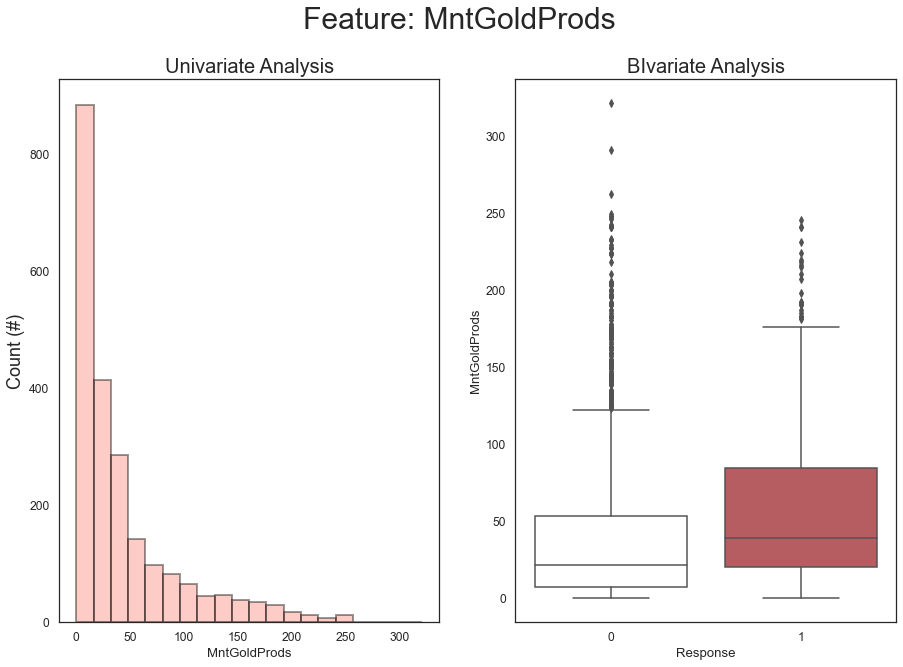

In [31]:
# Variável: MntGoldProds
plt.figure(figsize = (15,10))
plt.suptitle('Feature: MntGoldProds \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['MntGoldProds'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'MntGoldProds', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='NumDealsPurchases'>

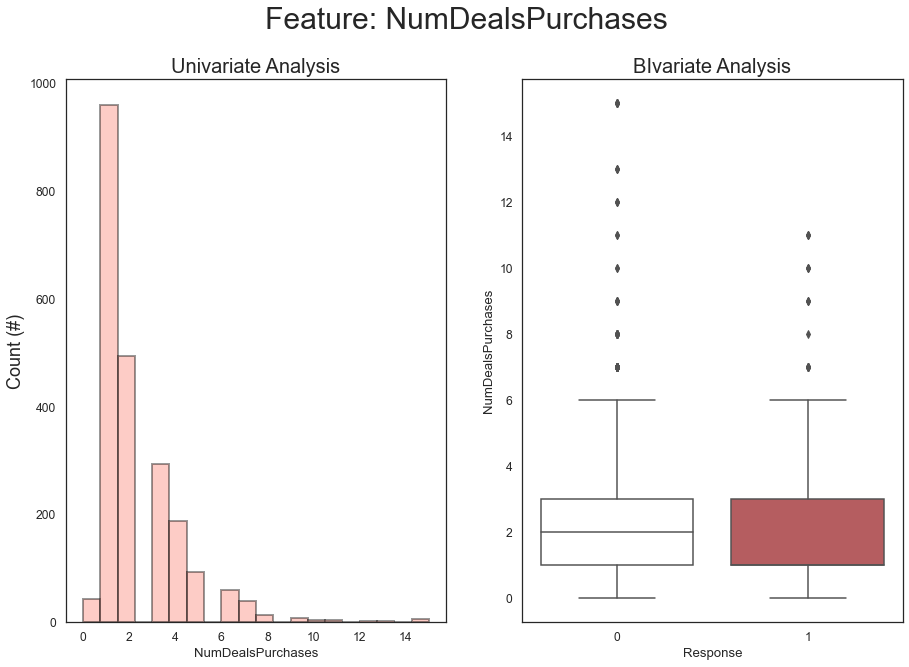

In [32]:
# Variável: NumDealsPurchases
plt.figure(figsize = (15,10))
plt.suptitle('Feature: NumDealsPurchases \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['NumDealsPurchases'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'NumDealsPurchases', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='NumWebPurchases'>

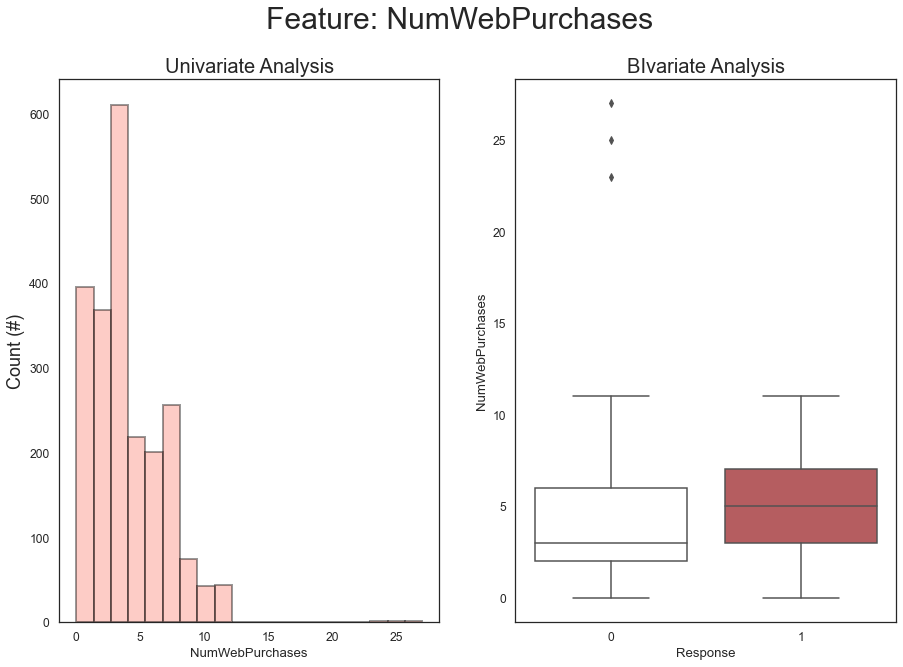

In [33]:
# Variável: NumWebPurchases
plt.figure(figsize = (15,10))
plt.suptitle('Feature: NumWebPurchases \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['NumWebPurchases'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'NumWebPurchases', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, possui outliers !!!

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='NumCatalogPurchases'>

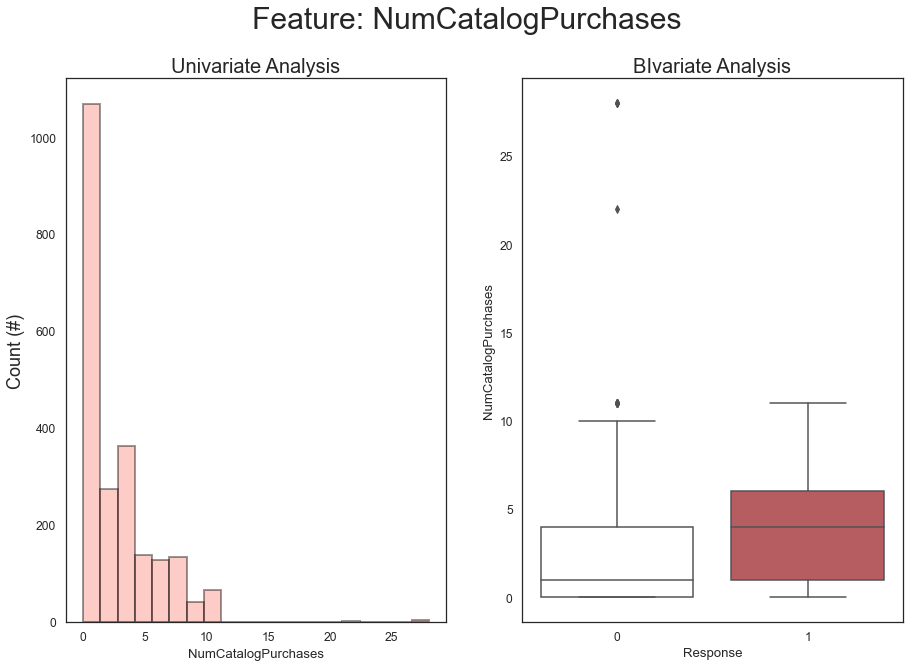

In [34]:
# Variável: NumCatalogPurchases
plt.figure(figsize = (15,10))
plt.suptitle('Feature: NumCatalogPurchases \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['NumCatalogPurchases'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'NumCatalogPurchases', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, possui outliers !!!

C:\Anaconda3\envs\benedito_deep\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='NumStorePurchases'>

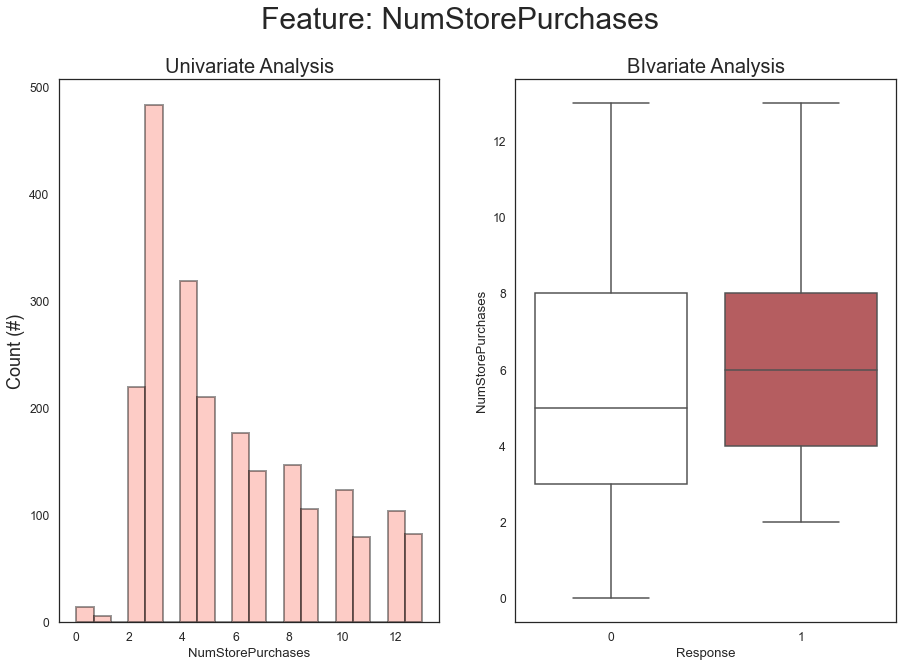

In [35]:
# Variável: NumStorePurchases
plt.figure(figsize = (15,10))
plt.suptitle('Feature: NumStorePurchases \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.distplot(df_aux['NumStorePurchases'], kde = False, bins = 20, color = 'salmon', hist_kws = dict(edgecolor = "black", linewidth=2))

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
my_pal = {1: "r", 0: 'w'}
sns.boxplot(x = "Response", y = 'NumStorePurchases', data = df_aux,palette=my_pal)

# OBS: Comportamento diferenciado entre os dois grupos, sem outliers

## 3.2) Variáveis Qualitativas: análises univariada e bivariada

In [36]:
vars_cat = ['Education', 'Marital_Status', 'AcceptedCmp1','AcceptedCmp2',
            'AcceptedCmp3','AcceptedCmp4','AcceptedCmp5', 'Complain', 'Response']

In [37]:
df_aux_2 = df_2[vars_cat]   

In [38]:
# Breve sumário estatístico das variáveis
df_aux_2.describe(include = 'all')

,Education,Marital_Status,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Response
count,2216,2216,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
unique,5,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Graduation,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1116,857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.064079,0.013538,0.073556,0.074007,0.073105,0.009477,0.150271
std,NaN,NaN,0.244950,0.115588,0.261106,0.261842,0.260367,0.096907,0.357417
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
# Setando o tamanho das fontes
sns.set(font_scale = 1.1)
sns.set_style('white')

<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='Education'>

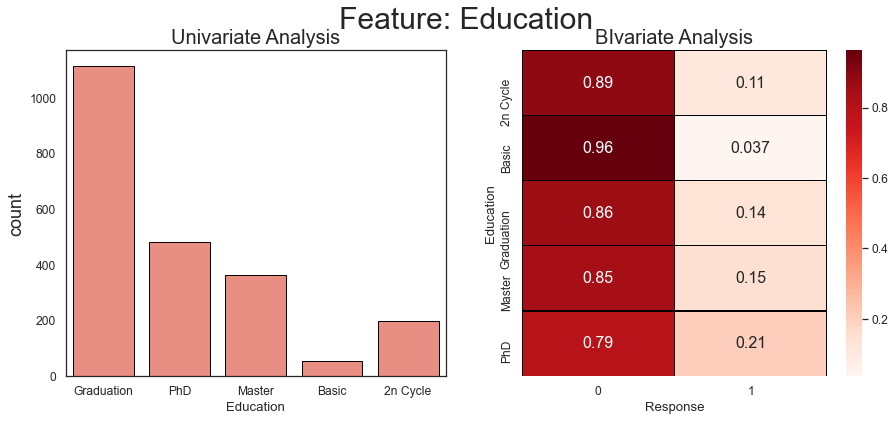

In [120]:
# Variável: Education
plt.figure(figsize = (15,6))
plt.suptitle('Feature: Education \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = 'Education', data = df_aux_2, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
data_crosstab = pd.crosstab(df_aux_2['Education'],df_aux_2['Response'], margins = False, normalize = 'index') 
sns.heatmap(data_crosstab, annot=True, annot_kws={"size": 16}, cmap="Reds", linewidths=0.2, linecolor='black') 

# OBS: Deve agrupar a categoria basica, tentar calcular com percentual tb

<AxesSubplot:title={'center':'BIvariate Analysis'}, xlabel='Response', ylabel='Marital_Status'>

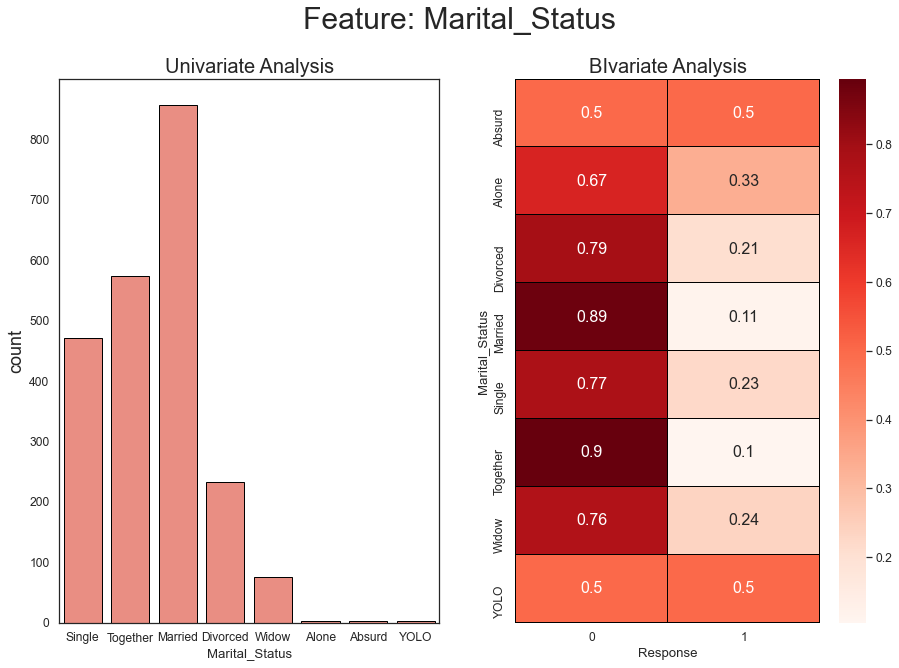

In [41]:
# Variável: Marital_Status
plt.figure(figsize = (15,10))
plt.suptitle('Feature: Marital_Status \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = 'Marital_Status', data = df_aux_2, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('BIvariate Analysis', fontsize=20)
data_crosstab = pd.crosstab(df_aux_2['Marital_Status'],df_aux_2['Response'], margins = False, normalize = 'index') 
sns.heatmap(data_crosstab, annot=True, annot_kws={"size": 16}, cmap="Reds", linewidths=0.2, linecolor='black') 

# OBS: Deve agrupar a categoria basica, tentar calcular com percentual tb, criar outros pq tem coisas estranhas

<AxesSubplot:title={'center':'Bivariate Analysis'}, xlabel='Response', ylabel='Complain'>

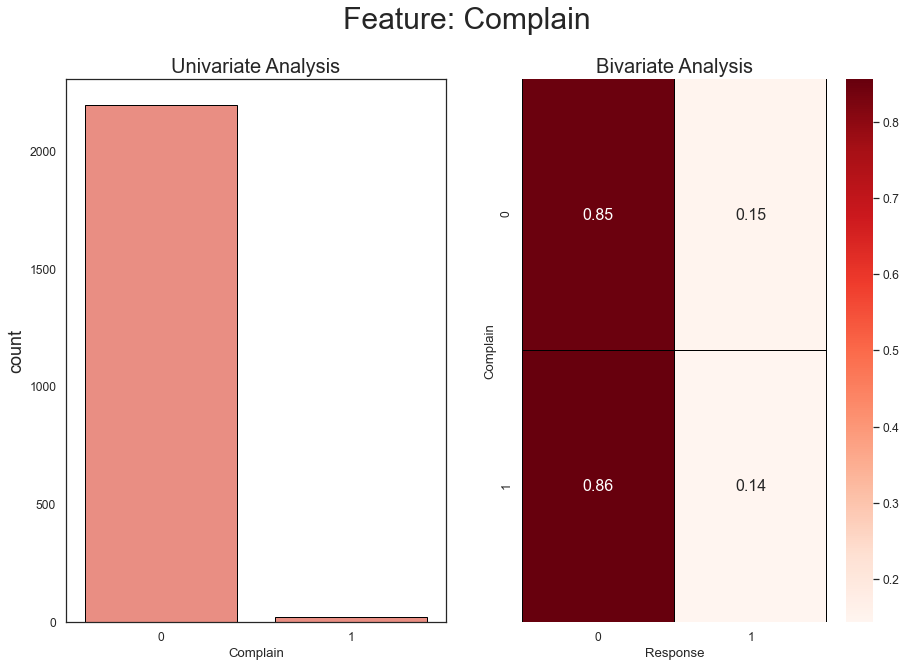

In [42]:
# Variável: Complain
plt.figure(figsize = (15,10))
plt.suptitle('Feature: Complain \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = 'Complain', data = df_aux_2, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('Bivariate Analysis', fontsize=20)
data_crosstab = pd.crosstab(df_aux_2['Complain'],df_aux_2['Response'], margins = False, normalize = 'index') 
sns.heatmap(data_crosstab, annot=True, annot_kws={"size": 16}, cmap="Reds", linewidths=0.2, linecolor='black') 

# OBS: 1 não representa quase nada da base, nem vai entrar no modelo

<AxesSubplot:title={'center':'Bivariate Analysis'}, xlabel='Response', ylabel='AcceptedCmp1'>

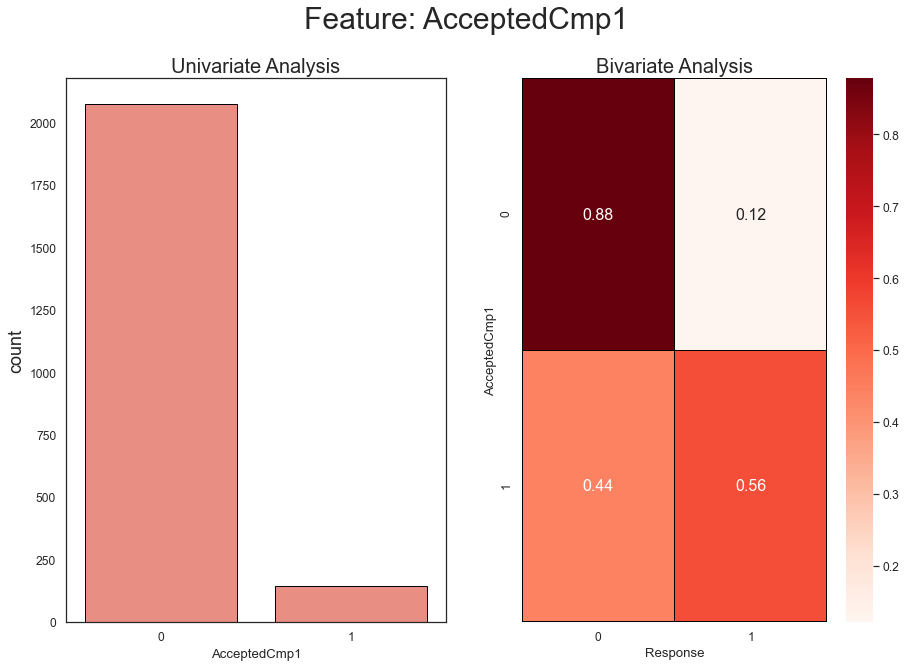

In [43]:
# Variável: AcceptedCmp1
plt.figure(figsize = (15,10))
plt.suptitle('Feature: AcceptedCmp1 \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = 'AcceptedCmp1', data = df_aux_2, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('Bivariate Analysis', fontsize=20)
data_crosstab = pd.crosstab(df_aux_2['AcceptedCmp1'],df_aux_2['Response'], margins = False, normalize = 'index') 
sns.heatmap(data_crosstab, annot=True, annot_kws={"size": 16}, cmap="Reds", linewidths=0.2, linecolor='black') 

# OBS: Taxa baixa, precisa ver em % na analise bivariada

<AxesSubplot:title={'center':'Bivariate Analysis'}, xlabel='Response', ylabel='AcceptedCmp2'>

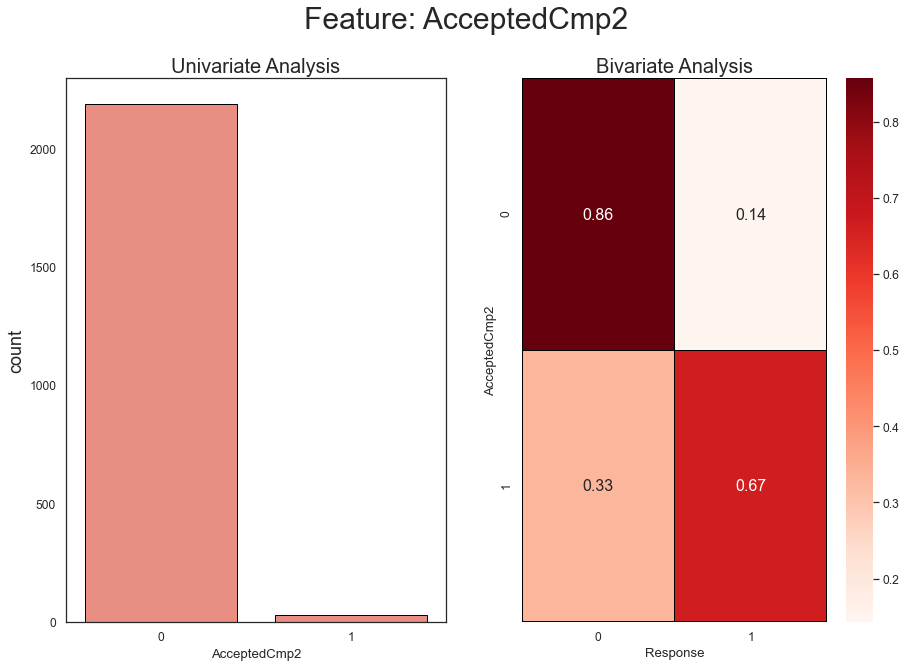

In [44]:
# Variável: AcceptedCmp2
plt.figure(figsize = (15,10))
plt.suptitle('Feature: AcceptedCmp2 \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = 'AcceptedCmp2', data = df_aux_2, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('Bivariate Analysis', fontsize=20)
data_crosstab = pd.crosstab(df_aux_2['AcceptedCmp2'],df_aux_2['Response'], margins = False, normalize = 'index') 
sns.heatmap(data_crosstab, annot=True, annot_kws={"size": 16}, cmap="Reds", linewidths=0.2, linecolor='black') 

# OBS: Taxa baixa, precisa ver em % na analise bivariada

<AxesSubplot:title={'center':'Bivariate Analysis'}, xlabel='Response', ylabel='AcceptedCmp3'>

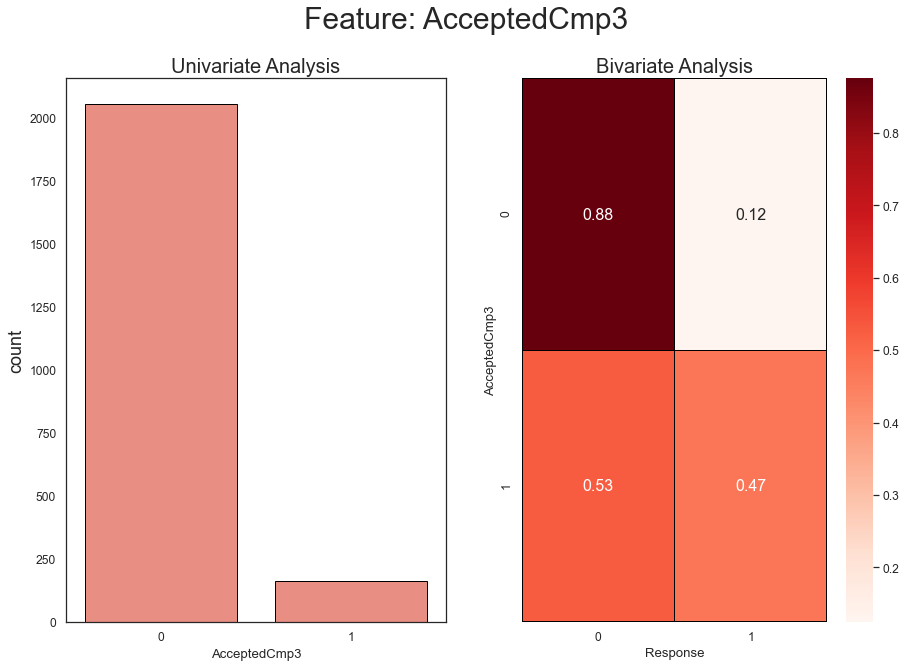

In [45]:
# Variável: AcceptedCmp3
plt.figure(figsize = (15,10))
plt.suptitle('Feature: AcceptedCmp3 \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = 'AcceptedCmp3', data = df_aux_2, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('Bivariate Analysis', fontsize=20)
data_crosstab = pd.crosstab(df_aux_2['AcceptedCmp3'],df_aux_2['Response'], margins = False, normalize = 'index') 
sns.heatmap(data_crosstab, annot=True, annot_kws={"size": 16}, cmap="Reds", linewidths=0.2, linecolor='black') 

# OBS: Taxa baixa, precisa ver em % na analise bivariada

<AxesSubplot:title={'center':'Bivariate Analysis'}, xlabel='Response', ylabel='AcceptedCmp4'>

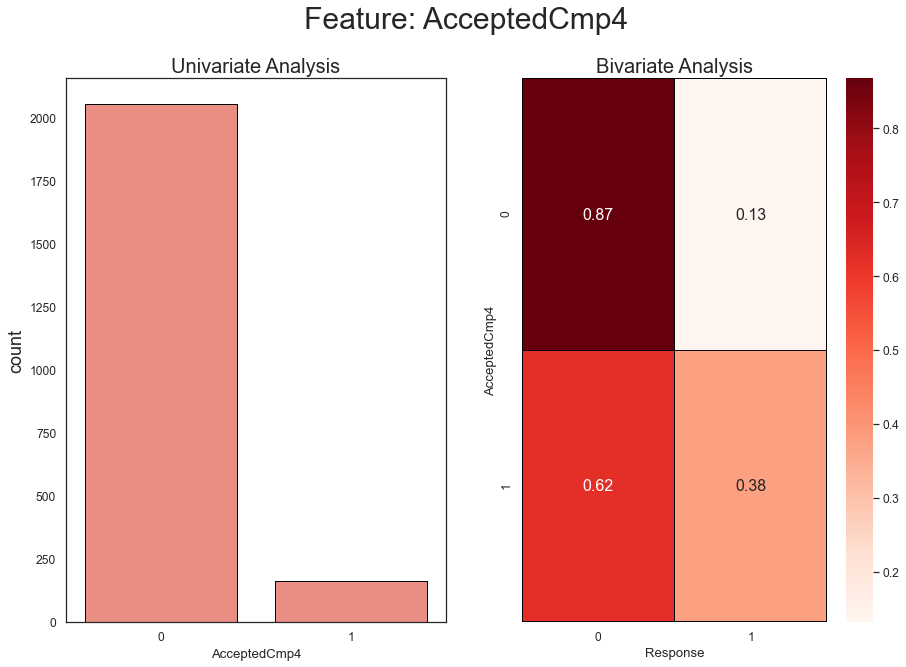

In [46]:
# Variável: AcceptedCmp4
plt.figure(figsize = (15,10))
plt.suptitle('Feature: AcceptedCmp4 \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = 'AcceptedCmp4', data = df_aux_2, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('Bivariate Analysis', fontsize=20)
data_crosstab = pd.crosstab(df_aux_2['AcceptedCmp4'],df_aux_2['Response'], margins = False, normalize = 'index') 
sns.heatmap(data_crosstab, annot=True, annot_kws={"size": 16}, cmap="Reds", linewidths=0.2, linecolor='black') 

# OBS: Taxa baixa, precisa ver em % na analise bivariada

<AxesSubplot:title={'center':'Bivariate Analysis'}, xlabel='Response', ylabel='AcceptedCmp5'>

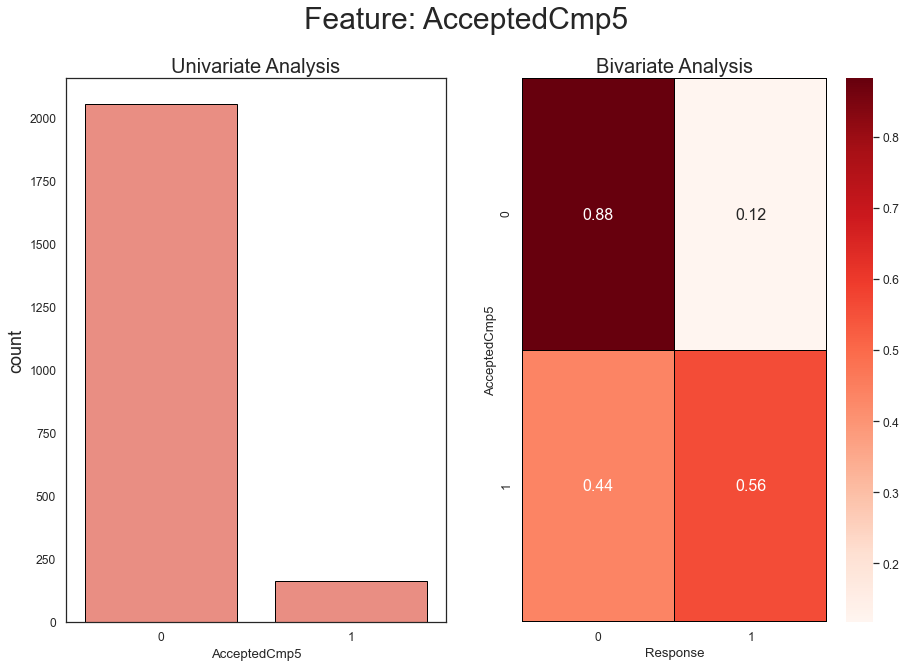

In [47]:
# Variável: AcceptedCmp5
plt.figure(figsize = (15,10))
plt.suptitle('Feature: AcceptedCmp5 \n', fontsize=30)
#
plt.subplot(1, 2, 1)
plt.title('Univariate Analysis', fontsize=20)
plt.ylabel('Count (#)', fontsize = 18)
sns.countplot(x = 'AcceptedCmp5', data = df_aux_2, color = 'salmon', edgecolor = 'black')

plt.subplot(1, 2, 2)
plt.title('Bivariate Analysis', fontsize=20)
data_crosstab = pd.crosstab(df_aux_2['AcceptedCmp5'],df_aux_2['Response'], margins = False, normalize = 'index') 
sns.heatmap(data_crosstab, annot=True, annot_kws={"size": 16}, cmap="Reds", linewidths=0.2, linecolor='black') 

# OBS: Taxa baixa, precisa ver em % na analise bivariada

## 4) Organização da base de dados para modelagem e segmentação

In [ ]:
# remover os outliers redocificar algumas variáveis categóricas

## 4.1) Divisão entre treino e teste
#### Uma vez que o uso de k-fold cross-validation demanda grande capacidade computacional, vamos utilizar a estratégia hold out.
#### Embora seja mais simples, é mais garantido que a minha máquina consiga rodar. Vamos adotar a estratégia hold out 50/50.

In [48]:
train_data = df.sample(1108, random_state = 135711)
test_data = df[~df.ID.isin(train_data.ID)]

## 4.2) Outliers e recodificações

In [49]:
vars_num.remove("Response")
vars_cat.remove("Response")
vars_cat.remove('AcceptedCmp1')
vars_cat.remove('AcceptedCmp2')
vars_cat.remove('AcceptedCmp3')
vars_cat.remove('AcceptedCmp4')
vars_cat.remove('AcceptedCmp5')
vars_cat.remove('Complain')
for feat in vars_num:
    l_inf = np.quantile(train_data.loc[:,feat],0.025) 
    l_sup = np.quantile(train_data.loc[:,feat],0.975)
    train_data.loc[train_data.loc[:,feat]<l_inf,feat] = l_inf
    train_data.loc[train_data.loc[:,feat]>l_sup,feat] = l_sup   
    test_data.loc[test_data.loc[:,feat]<l_inf,feat] = l_inf
    test_data.loc[test_data.loc[:,feat]>l_sup,feat] = l_sup  

C:\Anaconda3\envs\benedito_deep\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Anaconda3\envs\benedito_deep\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Anaconda3\envs\benedito_deep\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

C:\Anaconda3\envs\benedito_deep\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Anaconda3\envs\benedito_deep\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Anaconda3\envs\benedito_deep\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [50]:
def marital_status(x):
    if x in ('Alone', 'Absurd', 'YOLO'):
        return "other"
    else:
        return x

In [51]:
train_data['Marital_Status'] = train_data['Marital_Status'].apply(marital_status)
test_data['Marital_Status'] = test_data['Marital_Status'].apply(marital_status)

C:\Anaconda3\envs\benedito_deep\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 5) Segmentação de negócio: árvore de decisão
#### Uma segmentação deve ser facilmente interpretável e intuitiva a ponto de ser construída com uma query.
#### Não precisa necessariamente ter caráter preditivo, por isso vamos juntar as duas bases de treino e teste num primeiro momento.

In [52]:
data_seg = pd.concat([train_data, test_data], axis = 0)

In [53]:
drop_feats = ['ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'Year_Birth']
data_seg_ = data_seg.drop(drop_feats, axis = 1)

In [54]:
data_seg_ = pd.get_dummies(data = data_seg_, columns = vars_cat, drop_first = True)

In [55]:
data_seg = pd.get_dummies(data = data_seg, columns = vars_cat, drop_first = True)

In [56]:
dtree = DecisionTreeClassifier(max_depth = 4, min_samples_split=30, min_samples_leaf = 30,
                              criterion = 'entropy', min_impurity_decrease=1e-07, random_state=1234)

In [57]:
X = data_seg_.drop(['Response'], axis = 1)
y = data_seg_['Response']

In [58]:
class_tree = dtree.fit(X, y)

In [59]:
acc = metrics_sk.accuracy_score(y, class_tree.predict(X))
f1 = metrics_sk.f1_score(y, class_tree.predict(X))
precision = metrics_sk.precision_score(y, class_tree.predict(X))
recall = metrics_sk.recall_score(y, class_tree.predict(X))
auc = metrics_sk.roc_auc_score(y, class_tree.predict_proba(X)[:,1])

print('accuracy: ',acc)
print('precision: ',precision)
print('recall: ',recall)
print('F1: ',f1)
print('AUC: ',auc)

accuracy:  0.8822202166064982
precision:  0.7068965517241379
recall:  0.36936936936936937
F1:  0.48520710059171596
AUC:  0.8284492671109771


In [60]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] 
                    if i != _tree.TREE_UNDEFINED else "undefined!" 
                    for i in tree_.feature]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node])))

    recurse(0, 1)

In [61]:
tree_to_code(class_tree, X.columns)

def tree(Income, Kidhome, Teenhome, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Age, Tenure, Education_Basic, Education_Graduation, Education_Master, Education_PhD, Marital_Status_Married, Marital_Status_Single, Marital_Status_Together, Marital_Status_Widow, Marital_Status_other):
    if AcceptedCmp5 <= 0.5:
        if AcceptedCmp3 <= 0.5:
            if Tenure <= 96.5:
                if Recency <= 40.5:
                    return 0
                else:  # if Recency > 40.5
                    return 0
            else:  # if Tenure > 96.5
                if Education_PhD <= 0.5:
                    return 0
                else:  # if Education_PhD > 0.5
                    return 0
        else:  # if AcceptedCmp3 > 0.5
            if Recency <= 19.5:
       

In [62]:
def decision_rule(df,i):
    
    if (df.iloc[i,:]['AcceptedCmp5'] <= 0.5 and
        df.iloc[i,:]['AcceptedCmp3'] <= 0.5 and
        df.iloc[i,:]['Tenure'] <= 96.5 and
        df.iloc[i,:]['Recency'] <= 40.5):        
        return 'grupo_1_n_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] <= 0.5 and
        df.iloc[i,:]['AcceptedCmp3'] <= 0.5 and
        df.iloc[i,:]['Tenure'] <= 96.5 and
        df.iloc[i,:]['Recency'] > 40.5):        
        return 'grupo_2_n_evento'

    
    if (df.iloc[i,:]['AcceptedCmp5'] <= 0.5 and
        df.iloc[i,:]['AcceptedCmp3'] <= 0.5 and
        df.iloc[i,:]['Tenure'] > 96.5 and
        df.iloc[i,:]['Education_PhD'] <= 0.5):        
        return 'grupo_3_n_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] <= 0.5 and
        df.iloc[i,:]['AcceptedCmp3'] <= 0.5 and
        df.iloc[i,:]['Tenure'] > 96.5 and
        df.iloc[i,:]['Education_PhD'] > 0.5):        
        return 'grupo_4_n_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] <= 0.5 and
        df.iloc[i,:]['AcceptedCmp3'] > 0.5 and
        df.iloc[i,:]['Recency'] <= 19.5):        
        return 'grupo_5_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] <= 0.5 and
        df.iloc[i,:]['AcceptedCmp3'] > 0.5 and
        df.iloc[i,:]['Recency'] > 19.5 and
        df.iloc[i,:]['Tenure'] <= 92.5):         
        return 'grupo_6_n_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] <= 0.5 and
        df.iloc[i,:]['AcceptedCmp3'] > 0.5 and
        df.iloc[i,:]['Recency'] > 19.5 and
        df.iloc[i,:]['Tenure'] > 92.5):         
        return 'grupo_7_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] > 0.5 and
        df.iloc[i,:]['AcceptedCmp1'] <= 0.5 and
        df.iloc[i,:]['Recency'] <= 29.5):         
        return 'grupo_8_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] > 0.5 and
        df.iloc[i,:]['AcceptedCmp1'] <= 0.5 and
        df.iloc[i,:]['Recency'] > 29.5 and
        df.iloc[i,:]['Tenure'] <= 89.0):         
        return 'grupo_9_n_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] > 0.5 and
        df.iloc[i,:]['AcceptedCmp1'] <= 0.5 and
        df.iloc[i,:]['Recency'] > 29.5 and
        df.iloc[i,:]['Tenure'] > 89.0):         
        return 'grupo_10_n_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] > 0.5 and
        df.iloc[i,:]['AcceptedCmp1'] > 0.5 and
        df.iloc[i,:]['Tenure'] <= 88.5):         
        return 'grupo_11_evento'

    if (df.iloc[i,:]['AcceptedCmp5'] > 0.5 and
        df.iloc[i,:]['AcceptedCmp1'] > 0.5 and
        df.iloc[i,:]['Tenure'] > 88.5):         
        return 'grupo_12_evento'

In [63]:
groups = [decision_rule(data_seg, i) for i in range(data_seg.shape[0])]

In [64]:
data_seg['grupos'] = groups

### Resultado da campanha enviando-se oferta para a base toda (ignorando missings removidos):

In [65]:
print("Receita: ", (data_seg['Z_Revenue']*data_seg['Response']).sum(),'\n')
print("Custo de contato: ", data_seg['Z_CostContact'].sum(),'\n')
print("Resultado operacional: ", (data_seg['Z_Revenue']*data_seg['Response']).sum()-data_seg['Z_CostContact'].sum())
print("Margem operacional: ", ((data_seg['Z_Revenue']*data_seg['Response']).sum()-data_seg['Z_CostContact'].sum())/(data_seg['Z_Revenue']*data_seg['Response']).sum())


Receita:  3663 

Custo de contato:  6648 

Resultado operacional:  -2985
Margem operacional:  -0.8149058149058149


### Resultado da campanha enviando-se oferta para os clientes da segmentação (ignorando missings removidos):

In [66]:
publico_seg = data_seg[data_seg['grupos'].isin(['grupo_12_evento','grupo_11_evento','grupo_8_evento',
                                              'grupo_7_evento','grupo_5_evento'])]

In [67]:
print("Receita: ", (publico_seg['Z_Revenue']*publico_seg['Response']).sum(),'\n')
print("Custo de contato: ", publico_seg['Z_CostContact'].sum(),'\n')
print("Resultado operacional: ", (publico_seg['Z_Revenue']*publico_seg['Response']).sum()-publico_seg['Z_CostContact'].sum())
print("Margem operacional: ", ((publico_seg['Z_Revenue']*publico_seg['Response']).sum()-publico_seg['Z_CostContact'].sum())/(publico_seg['Z_Revenue']*publico_seg['Response']).sum())


Receita:  1353 

Custo de contato:  522 

Resultado operacional:  831
Margem operacional:  0.614190687361419


In [68]:
publico_seg.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Tenure,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_other,grupos
820,9493,1980,76412.000,0.0,0.0,2013-05-05,15.0,840.0,53.0,804.0,23.0,71.0,17.0,1.0,5.0,4.0,8.0,3,0,0,1,1,0,0,3,11,1,41.0,91,0,0,0,1,0,1,0,0,0,grupo_12_evento
1179,5735,1991,89758.025,0.0,0.0,2014-02-13,29.0,1156.0,120.0,806.6,94.0,144.0,96.0,1.0,3.0,4.0,10.0,1,0,0,1,0,0,0,3,11,0,31.0,82,0,0,1,0,0,1,0,0,0,grupo_8_evento
1005,7453,1954,36130.000,0.0,1.0,2013-02-02,46.0,157.0,43.0,127.0,68.0,56.0,37.0,6.0,3.0,8.0,4.0,4,1,0,0,0,0,0,3,11,1,67.0,94,0,1,0,0,0,1,0,0,0,grupo_7_evento
894,8800,1943,48948.000,0.0,0.0,2013-02-01,53.0,437.0,8.0,206.0,160.0,49.0,42.0,2.0,7.0,10.0,5.0,6,1,0,0,0,0,0,3,11,1,74.0,94,0,0,0,1,0,0,0,0,0,grupo_7_evento
1153,5031,1974,83145.000,0.0,0.0,2012-09-22,14.0,777.0,35.0,731.0,39.0,137.0,114.0,1.0,5.0,9.0,11.0,2,0,0,1,0,0,0,3,11,1,47.0,99,0,1,0,0,0,0,1,0,0,grupo_8_evento


In [69]:
describe = pd.DataFrame()
describe['Count'] = (publico_seg.groupby('grupos')['ID'].count())
describe['Income'] = (publico_seg.groupby('grupos')['Income'].mean())
describe['Kidhome'] = (publico_seg.groupby('grupos')['Kidhome'].mean())
describe['Teenhome'] = (publico_seg.groupby('grupos')['Teenhome'].mean())
describe['Recency'] = (publico_seg.groupby('grupos')['Recency'].mean())
describe['MntWines'] = (publico_seg.groupby('grupos')['MntWines'].mean())
describe['MntFruits'] = (publico_seg.groupby('grupos')['MntFruits'].mean())
describe['MntMeatProducts'] = (publico_seg.groupby('grupos')['MntMeatProducts'].mean())
describe['MntFishProducts'] = (publico_seg.groupby('grupos')['MntFishProducts'].mean())
describe['MntSweetProducts'] = (publico_seg.groupby('grupos')['MntSweetProducts'].mean())
describe['MntGoldProds'] = (publico_seg.groupby('grupos')['MntGoldProds'].mean())
describe['NumDealsPurchases'] = (publico_seg.groupby('grupos')['NumDealsPurchases'].mean())
describe['NumWebPurchases'] = (publico_seg.groupby('grupos')['NumWebPurchases'].mean())
describe['NumCatalogPurchases'] = (publico_seg.groupby('grupos')['NumCatalogPurchases'].mean())
describe['NumStorePurchases'] = (publico_seg.groupby('grupos')['NumStorePurchases'].mean())
describe['NumWebVisitsMonth'] = (publico_seg.groupby('grupos')['NumWebVisitsMonth'].mean())
describe['AcceptedCmp3'] = (publico_seg.groupby('grupos')['AcceptedCmp3'].mean())
describe['AcceptedCmp4'] = (publico_seg.groupby('grupos')['AcceptedCmp4'].mean())
describe['AcceptedCmp5'] = (publico_seg.groupby('grupos')['AcceptedCmp5'].mean())
describe['AcceptedCmp1'] = (publico_seg.groupby('grupos')['AcceptedCmp1'].mean())
describe['AcceptedCmp2'] = (publico_seg.groupby('grupos')['AcceptedCmp2'].mean())
describe['Complain'] = (publico_seg.groupby('grupos')['Complain'].mean())
describe['Age'] = (publico_seg.groupby('grupos')['Age'].mean())
describe['Tenure'] = (publico_seg.groupby('grupos')['Tenure'].mean())
describe['Education_Basic'] = (publico_seg.groupby('grupos')['Education_Basic'].mean())
describe['Education_Graduation'] = (publico_seg.groupby('grupos')['Education_Graduation'].mean())
describe['Education_Master'] = (publico_seg.groupby('grupos')['Education_Master'].mean())
describe['Education_PhD'] = (publico_seg.groupby('grupos')['Education_PhD'].mean())
describe['Marital_Status_Married'] = (publico_seg.groupby('grupos')['Marital_Status_Married'].mean())
describe['Marital_Status_Single'] = (publico_seg.groupby('grupos')['Marital_Status_Single'].mean())
describe['Marital_Status_Together'] = (publico_seg.groupby('grupos')['Marital_Status_Together'].mean())
describe['Marital_Status_Widow'] = (publico_seg.groupby('grupos')['Marital_Status_Widow'].mean())
describe['Marital_Status_other'] = (publico_seg.groupby('grupos')['Marital_Status_other'].mean())





In [70]:
describe

,Count,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age,Tenure,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_other
grupos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
grupo_11_evento,35,81967.408571,0.028571,0.057143,43.885714,894.367857,65.215714,508.257143,86.170000,77.827143,68.475714,1.057143,5.028571,6.314286,8.200000,2.314286,0.314286,0.314286,1,1.000000,0.114286,0.000000,46.657143,83.542857,0.000000,0.685714,0.114286,0.142857,0.485714,0.200000,0.200000,0.000000,0.000000
grupo_12_evento,33,84848.765909,0.090909,0.090909,45.000000,822.629545,56.774242,425.103030,85.361364,67.312121,86.130303,1.090909,5.969697,6.909091,7.787879,3.666667,0.151515,0.606061,1,1.000000,0.212121,0.000000,52.575758,94.333333,0.000000,0.515152,0.151515,0.333333,0.333333,0.242424,0.272727,0.060606,0.030303
grupo_5_evento,30,45120.996667,0.533333,0.300000,9.600000,271.733333,23.288333,145.000000,28.299167,17.300000,53.133333,2.200000,4.766667,3.100000,4.733333,6.533333,1.000000,0.000000,0,0.066667,0.000000,0.000000,48.500000,89.200000,0.066667,0.400000,0.200000,0.200000,0.433333,0.233333,0.266667,0.000000,0.000000
grupo_7_evento,46,45595.865217,0.456522,0.391304,52.101087,394.760870,25.448913,166.960870,47.193478,27.159239,55.514130,2.847826,5.630435,3.956522,5.108696,6.934783,1.000000,0.000000,0,0.065217,0.000000,0.021739,50.217391,96.347826,0.065217,0.434783,0.108696,0.260870,0.347826,0.282609,0.195652,0.021739,0.000000
grupo_8_evento,30,80416.571667,0.000000,0.066667,16.000000,854.962500,54.943333,470.560000,69.965000,61.310833,73.710833,1.100000,5.966667,5.533333,7.800000,2.866667,0.066667,0.266667,1,0.000000,0.033333,0.000000,48.366667,90.466667,0.000000,0.466667,0.233333,0.200000,0.333333,0.200000,0.300000,0.066667,0.000000


In [71]:
# Aplicando o SVD truncado para realizar uma analise de coordenadas principais
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
A = describe.drop(['Count'], axis = 1)
A = scaler.fit_transform(describe.values)
r = 5

tsvd = TruncatedSVD(n_components=r) 
U = tsvd.fit_transform(A)
Sigma = tsvd.explained_variance_ratio_
Vt = tsvd.components_

In [72]:
U2 = pd.DataFrame(U).set_index(describe.index)

In [73]:
U2.reset_index(inplace = True)

In [74]:
U2.columns = ['grupos','coord1','coord2','coord3','coord4','coord5']

In [75]:
U2

,grupos,coord1,coord2,coord3,coord4,coord5
0,grupo_11_evento,-3.728285,-3.320126,-2.845057,-0.022110,3.171075e-15
1,grupo_12_evento,-4.172004,3.652735,0.038136,-1.498527,3.171075e-15
2,grupo_5_evento,5.166274,-2.066571,1.797171,-1.632346,3.171075e-15
3,grupo_7_evento,5.547073,2.202723,-2.020576,1.311986,3.171075e-15
4,grupo_8_evento,-2.813058,-0.468761,3.030325,1.840996,3.171075e-15


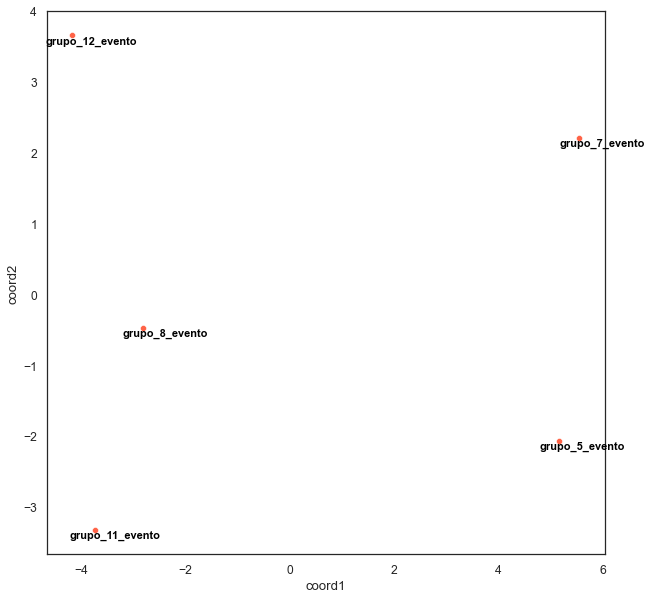

In [76]:
plt.figure(figsize = (10,10))
p1=sns.scatterplot(data=U2, x="coord1", y="coord2", marker="o", color="tomato")
 
# add annotations one by one with a loop
for line in range(0,U2.shape[0]):
     p1.text(U2.coord1[line]+1.25, U2.coord2[line], U2.grupos[line], horizontalalignment='right',
             verticalalignment='top', size='small', color='black', weight='semibold')

In [77]:
def segmenta(x):
    if x in ('grupo_11_evento','grupo_12_evento','grupo_8_evento'):
        return 'segmento_1'
    else:
        return 'segmento_2'

In [78]:
publico_seg['grupos'] = publico_seg['grupos'].apply(segmenta)

C:\Anaconda3\envs\benedito_deep\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
describe = pd.DataFrame()
describe['Count'] = (publico_seg.groupby('grupos')['ID'].count())
describe['Income'] = (publico_seg.groupby('grupos')['Income'].mean())
describe['Kidhome'] = (publico_seg.groupby('grupos')['Kidhome'].mean())
describe['Teenhome'] = (publico_seg.groupby('grupos')['Teenhome'].mean())
describe['Recency'] = (publico_seg.groupby('grupos')['Recency'].mean())
describe['MntWines'] = (publico_seg.groupby('grupos')['MntWines'].mean())
describe['MntFruits'] = (publico_seg.groupby('grupos')['MntFruits'].mean())
describe['MntMeatProducts'] = (publico_seg.groupby('grupos')['MntMeatProducts'].mean())
describe['MntFishProducts'] = (publico_seg.groupby('grupos')['MntFishProducts'].mean())
describe['MntSweetProducts'] = (publico_seg.groupby('grupos')['MntSweetProducts'].mean())
describe['MntGoldProds'] = (publico_seg.groupby('grupos')['MntGoldProds'].mean())
describe['NumDealsPurchases'] = (publico_seg.groupby('grupos')['NumDealsPurchases'].mean())
describe['NumWebPurchases'] = (publico_seg.groupby('grupos')['NumWebPurchases'].mean())
describe['NumCatalogPurchases'] = (publico_seg.groupby('grupos')['NumCatalogPurchases'].mean())
describe['NumStorePurchases'] = (publico_seg.groupby('grupos')['NumStorePurchases'].mean())
describe['NumWebVisitsMonth'] = (publico_seg.groupby('grupos')['NumWebVisitsMonth'].mean())
describe['AcceptedCmp3'] = (publico_seg.groupby('grupos')['AcceptedCmp3'].mean())
describe['AcceptedCmp4'] = (publico_seg.groupby('grupos')['AcceptedCmp4'].mean())
describe['AcceptedCmp5'] = (publico_seg.groupby('grupos')['AcceptedCmp5'].mean())
describe['AcceptedCmp1'] = (publico_seg.groupby('grupos')['AcceptedCmp1'].mean())
describe['AcceptedCmp2'] = (publico_seg.groupby('grupos')['AcceptedCmp2'].mean())
describe['Complain'] = (publico_seg.groupby('grupos')['Complain'].mean())
describe['Age'] = (publico_seg.groupby('grupos')['Age'].mean())
describe['Tenure'] = (publico_seg.groupby('grupos')['Tenure'].mean())
describe['Education_Basic'] = (publico_seg.groupby('grupos')['Education_Basic'].mean())
describe['Education_Graduation'] = (publico_seg.groupby('grupos')['Education_Graduation'].mean())
describe['Education_Master'] = (publico_seg.groupby('grupos')['Education_Master'].mean())
describe['Education_PhD'] = (publico_seg.groupby('grupos')['Education_PhD'].mean())
describe['Marital_Status_Married'] = (publico_seg.groupby('grupos')['Marital_Status_Married'].mean())
describe['Marital_Status_Single'] = (publico_seg.groupby('grupos')['Marital_Status_Single'].mean())
describe['Marital_Status_Together'] = (publico_seg.groupby('grupos')['Marital_Status_Together'].mean())
describe['Marital_Status_Widow'] = (publico_seg.groupby('grupos')['Marital_Status_Widow'].mean())
describe['Marital_Status_other'] = (publico_seg.groupby('grupos')['Marital_Status_other'].mean())
describe['Response'] = (publico_seg.groupby('grupos')['Response'].mean())

In [81]:
describe

,Count,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age,Tenure,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_other,Response
grupos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
segmento_1,98,82462.915561,0.040816,0.071429,35.724490,858.148214,59.228571,468.716327,80.936990,69.230357,76.023214,1.081633,5.632653,6.275510,7.938776,2.938776,0.183673,0.397959,1,0.693878,0.122449,0.000000,49.173469,89.295918,0.000000,0.561224,0.163265,0.224490,0.387755,0.214286,0.255102,0.040816,0.010204,0.755102
segmento_2,76,45408.417105,0.486842,0.355263,35.324342,346.197368,24.596053,158.292105,39.735197,23.267434,54.574342,2.592105,5.289474,3.618421,4.960526,6.776316,1.000000,0.000000,0,0.065789,0.000000,0.013158,49.539474,93.526316,0.065789,0.421053,0.144737,0.236842,0.381579,0.263158,0.223684,0.013158,0.000000,0.644737


<Figure size 1080x720 with 0 Axes>

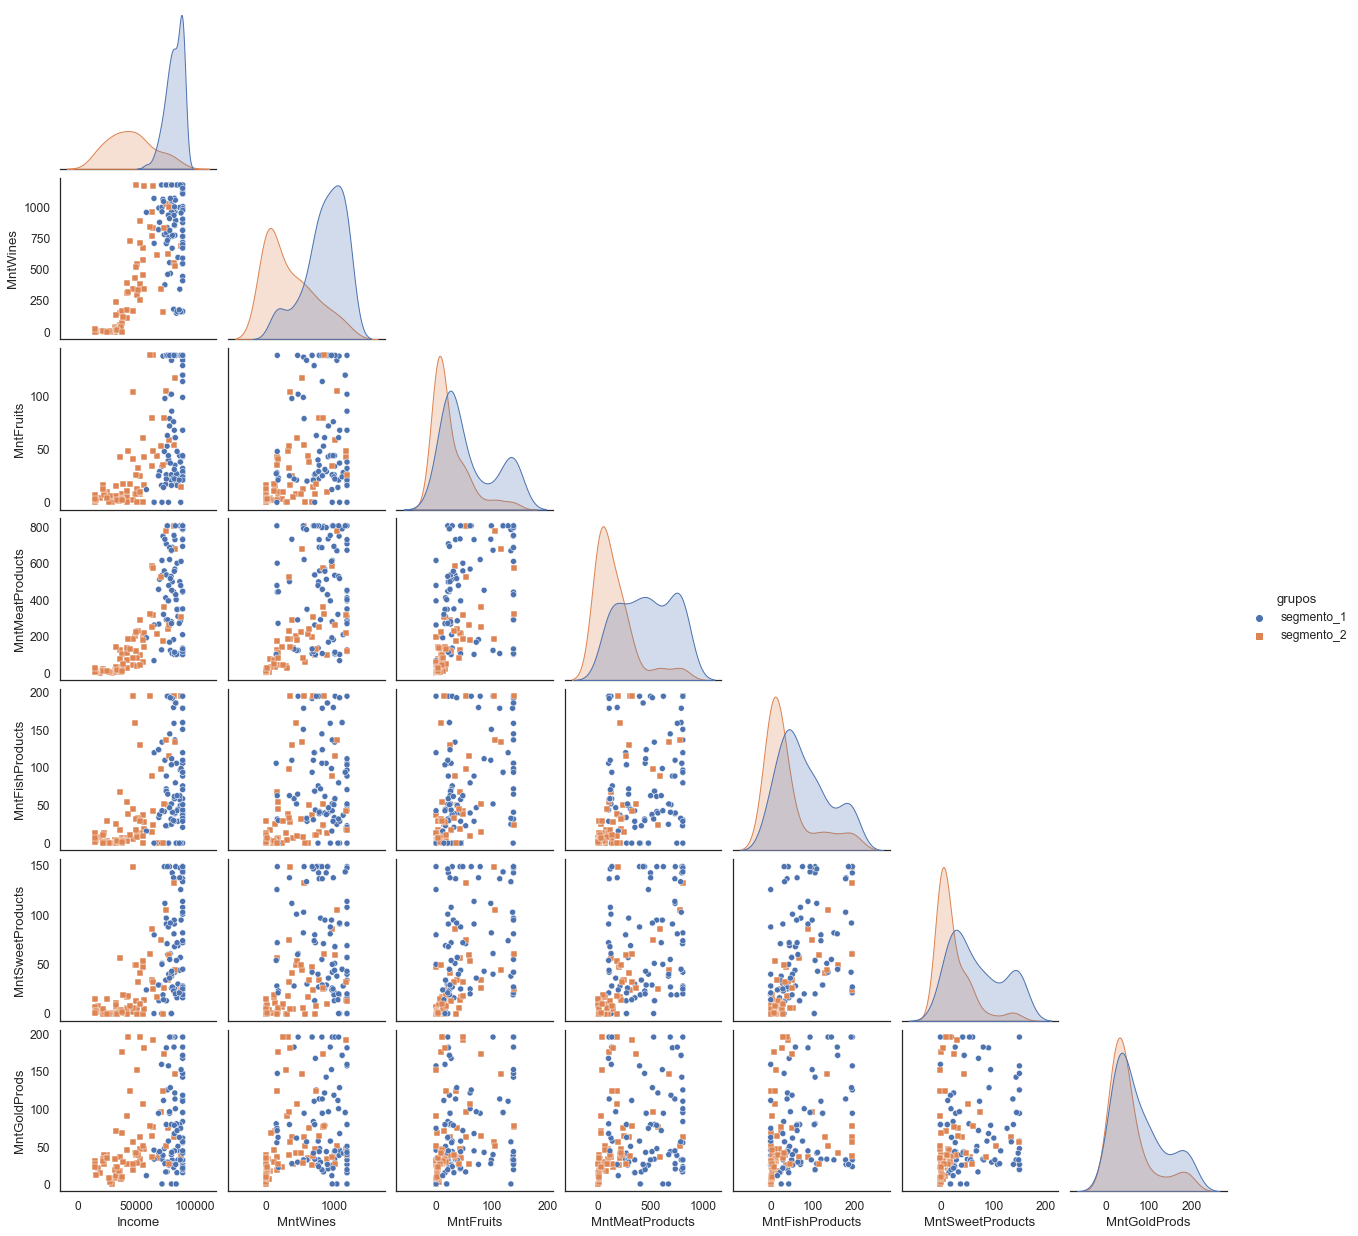

In [82]:
plt.figure(figsize = (15,10))
plt.suptitle('Renda e padrões de consumo \n', fontsize=30)
sns.pairplot(publico_seg[['Income','MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                     'MntGoldProds', 'grupos']], hue="grupos", markers=["o", "s"], corner = True)

In [83]:
describe

,Count,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age,Tenure,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_other,Response
grupos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
segmento_1,98,82462.915561,0.040816,0.071429,35.724490,858.148214,59.228571,468.716327,80.936990,69.230357,76.023214,1.081633,5.632653,6.275510,7.938776,2.938776,0.183673,0.397959,1,0.693878,0.122449,0.000000,49.173469,89.295918,0.000000,0.561224,0.163265,0.224490,0.387755,0.214286,0.255102,0.040816,0.010204,0.755102
segmento_2,76,45408.417105,0.486842,0.355263,35.324342,346.197368,24.596053,158.292105,39.735197,23.267434,54.574342,2.592105,5.289474,3.618421,4.960526,6.776316,1.000000,0.000000,0,0.065789,0.000000,0.013158,49.539474,93.526316,0.065789,0.421053,0.144737,0.236842,0.381579,0.263158,0.223684,0.013158,0.000000,0.644737


<Figure size 1080x720 with 0 Axes>

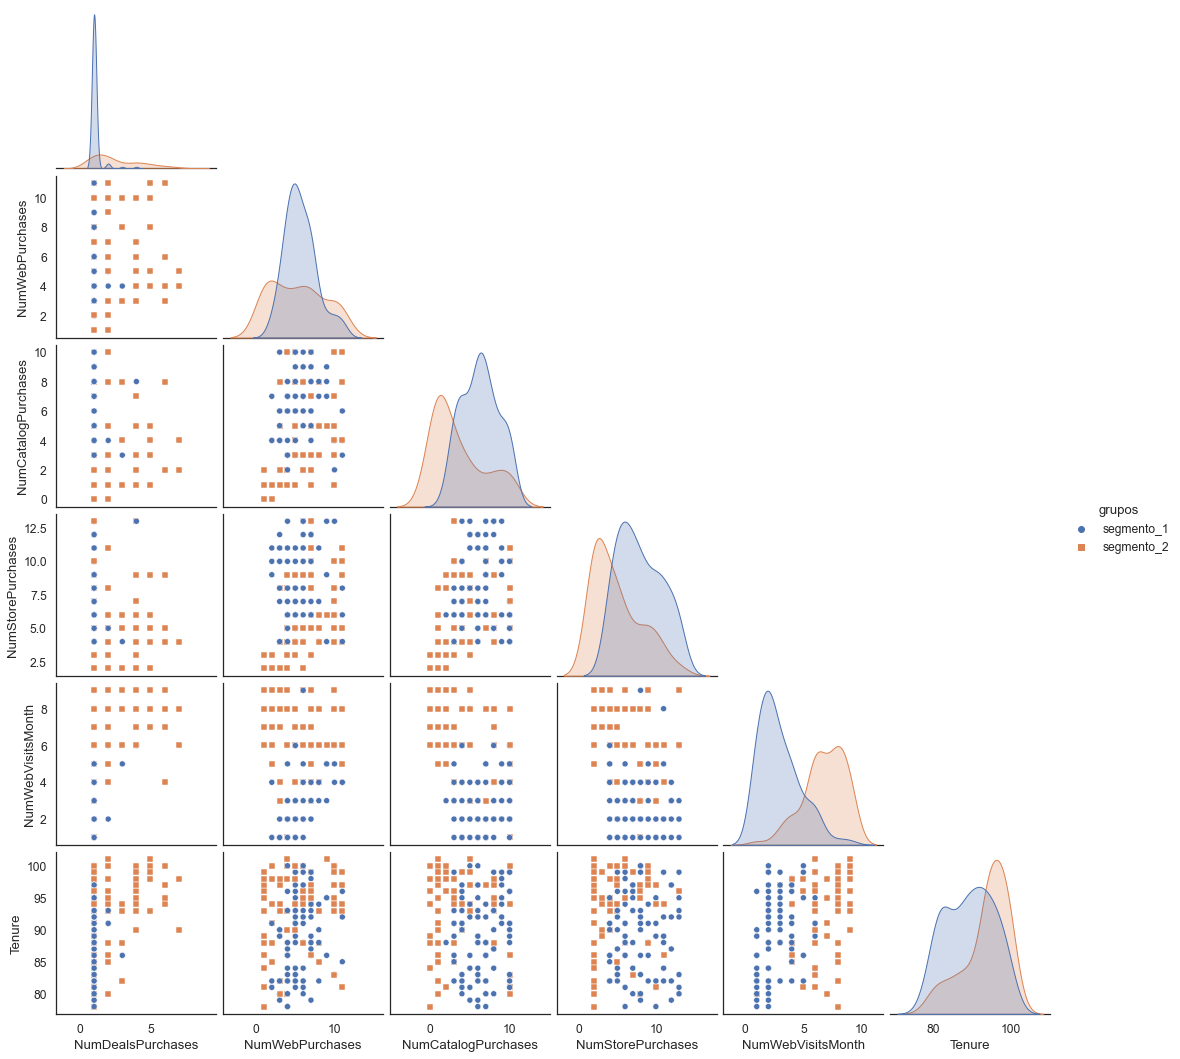

In [84]:
plt.figure(figsize = (15,10))
plt.suptitle('Renda e padrões de consumo \n', fontsize=30)
sns.pairplot(publico_seg[['NumDealsPurchases','NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Tenure',
                      'grupos']], hue="grupos", markers=["o", "s"], corner = True)
plt.show()

## 6) Desenvolvimento do modelo

### 6.1) Feature engineering

### WOE de variáveis categóricas multiníveis

In [85]:
def woe(df, feat, target):
    levels = {}
    df_feat = pd.DataFrame()
    df_feat['event_rate'] = df.groupby([feat])[target[0]].sum()/df.groupby([feat])[target[0]].count()
    df_feat['n_event_rate'] = 1-df_feat['event_rate']
    df_feat['woe'] = np.log((df_feat['event_rate']+0.0000001)/(df_feat['n_event_rate']+0.0000001))
    levels = {level: df_feat.loc[level,'woe'] for level in df_feat.index}
    return levels

In [86]:
for feat in vars_cat:
    levels = woe(train_data, feat, ['Response'])
    train_data.loc[~train_data.loc[:,feat].isna(),'woe_'+feat] = [levels[level] for level in train_data.loc[~train_data.loc[:,feat].isna(),feat]]
    train_data = train_data.drop([feat], axis = 1)
    test_data.loc[~test_data.loc[:,feat].isna(),'woe_'+feat] = [levels[level] for level in test_data.loc[~test_data.loc[:,feat].isna(),feat]]
    test_data = test_data.drop([feat], axis = 1)

C:\Anaconda3\envs\benedito_deep\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\envs\benedito_deep\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [87]:
X_train = train_data.drop(['ID', 'Year_Birth','Z_CostContact', 'Z_Revenue', 'Response', 'Dt_Customer'], axis = 1)
X_test = test_data.drop(['ID', 'Year_Birth','Z_CostContact', 'Z_Revenue', 'Response', 'Dt_Customer'], axis = 1)
y_train = train_data['Response']
y_test = test_data['Response']
full_data = pd.concat([train_data, test_data], axis = 0)
X_full = full_data.drop(['ID', 'Year_Birth','Z_CostContact', 'Z_Revenue', 'Response', 'Dt_Customer'], axis = 1)
y_full = full_data['Response']

## 6.2) LightGBM

In [ ]:
###GRID SEARCH LGBM 

#list_i = [2, 4, 6]
#list_j = [20,30, 50, 100]
#list_k = [20,30, 50, 100]
#list_l = [30,50, 100, 200]
#list_m = [0.05, 0.1, 0.15, 0.2, 0.25]

#for i in list_i:
#    for j in list_j:
#        for k in list_k:
#            for l in list_l:
#                for m in list_m:
#                    dtree = LGBMClassifier(max_depth = i, min_samples_split=j, min_data_in_leaf = k,n_estimators=l,
#                                min_impurity_decrease=1e-03, lambda_l1=0.3, lambda_l2=0.7, random_state=11235, eta = 0.005, learning_rate = m)
#                    class_tree = dtree.fit(X_train, y_train)
#                    auc_test = metrics_sk.roc_auc_score(y_test, class_tree.predict_proba(X_test)[:,1])
#                    print('depth: ', i, 'samples_split: ', j, 'data_in_leaf: ', k, 'n_estimators: ', l,'learning_rate: ',m, 'auc_test: ', auc_test)

In [88]:
dtree = LGBMClassifier(max_depth = 6, min_samples_split=50, min_data_in_leaf = 50,n_estimators=100,
                            min_impurity_decrease=1e-07, lambda_l1=0.5,
                       lambda_l2=0.5, random_state=11235, eta = 0.005, learning_rate = 0.1)

In [89]:
class_tree = dtree.fit(X_train, y_train)

In [90]:
acc_test = metrics_sk.accuracy_score(y_test, (class_tree.predict(X_test)))
f1_test = metrics_sk.f1_score(y_test, (class_tree.predict(X_test)))
precision_test = metrics_sk.precision_score(y_test, (class_tree.predict(X_test)))
recall_test = metrics_sk.recall_score(y_test, (class_tree.predict(X_test)))
auc_test = metrics_sk.roc_auc_score(y_test, class_tree.predict_proba(X_test)[:,1])

print('accuracy_test: ',acc_test)
print('precision_test: ',precision_test)
print('recall_test: ',recall_test)
print('F1_test: ',f1_test)
print('AUC_test: ',auc_test)

accuracy_test:  0.8871841155234657
precision_test:  0.6915887850467289
recall_test:  0.4457831325301205
F1_test:  0.542124542124542
AUC_test:  0.9229305758064104


In [91]:
full_data['score_LGBM'] = class_tree.predict_proba(X_full)[:,1]
full_data['predict_LGBM'] = class_tree.predict(X_full)

In [92]:
full_data.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Tenure,woe_Education,woe_Marital_Status,score_LGBM,predict_LGBM
944,8700,1986,14906.0,0.0,0.0,2012-12-22,86.0,7.0,7.0,14.0,7.0,16.0,15.0,3.0,2.0,1.0,3.0,7,0,0,0,0,0,0,3,11,0,35.0,96,-3.258094,-1.221466,0.023561,0
274,10967,1963,33378.0,1.0,1.0,2013-02-06,38.0,33.0,6.0,40.0,3.0,7.0,10.0,3.0,2.0,0.0,4.0,7,0,0,0,0,0,0,3,11,0,58.0,94,-1.814140,-1.439216,0.032662,0
978,3308,1952,35704.0,1.0,1.0,2014-01-03,54.0,30.0,9.0,12.0,2.0,11.0,30.0,3.0,2.0,0.0,4.0,4,0,0,0,0,0,0,3,11,0,69.0,83,-1.814140,-2.212972,0.004346,0
1681,5939,1971,38232.0,1.0,1.0,2014-01-17,84.0,43.0,5.0,28.0,7.0,6.0,33.0,4.0,3.0,1.0,3.0,5,0,0,0,0,0,0,3,11,0,50.0,83,-1.814140,-1.848454,0.005233,0
1398,3421,1968,63841.0,0.0,1.0,2013-04-21,64.0,635.0,15.0,100.0,20.0,7.0,131.0,1.0,9.0,3.0,9.0,6,0,0,0,0,0,0,3,11,0,53.0,92,-1.805004,-1.439216,0.026887,0


### Feature importances

In [93]:
from eli5.permutation_importance import get_score_importances

C:\Anaconda3\envs\benedito_deep\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda3\envs\benedito_deep\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
C:\Anaconda3\envs\benedito_deep\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (t

In [94]:
def score(X, y):
    y_pred = class_tree.predict(X)
    return metrics_sk.roc_auc_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, X_test.values, y_test)
feature_importances = np.mean(score_decreases, axis=0)
feature_importance_dict = {}
for i, feature_name in enumerate(X_test.columns):
    feature_importance_dict[feature_name]=feature_importances[i]
importance_lgbm = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:-1])

In [95]:
importance_lgbm

{'Recency': 0.04744199728851717,
 'woe_Marital_Status': 0.036035863198015064,
 'Teenhome': 0.02983910162944776,
 'MntMeatProducts': 0.026681247282122223,
 'AcceptedCmp1': 0.02356559997953602,
 'Tenure': 0.023318752717877887,
 'NumWebVisitsMonth': 0.017331747371652263,
 'AcceptedCmp3': 0.017294656332335734,
 'AcceptedCmp5': 0.01725756529301923,
 'Income': 0.01261862737574504,
 'MntWines': 0.009532397104340996,
 'NumCatalogPurchases': 0.008330135829944041,
 'NumDealsPurchases': 0.006947535364387547,
 'NumWebPurchases': 0.006838820249149546,
 'Kidhome': 0.004572429846775727,
 'MntGoldProds': 0.0039725782109329534,
 'NumStorePurchases': 0.0036438748625073902,
 'woe_Education': 0.0031552963446142,
 'Age': 0.0026219527792699982,
 'AcceptedCmp4': 0.0019824521013993126,
 'MntSweetProducts': 0.0003210293402911901,
 'AcceptedCmp2': 0.0,
 'Complain': 0.0,
 'MntFruits': -0.009001611541708176}

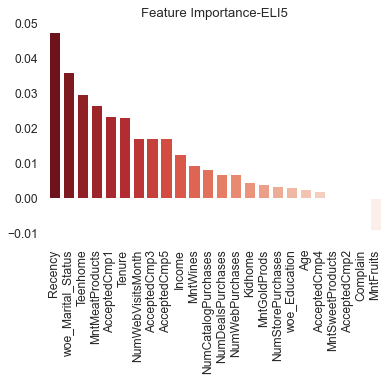

In [141]:
lgbm_plot=sns.barplot(x=list(importance_lgbm.keys()),y=list(importance_lgbm.values()), palette = 'Reds_r')
lgbm_plot.set_xticklabels(labels = importance_lgbm.keys(),rotation=90)
lgbm_plot.set_title("Feature Importance-ELI5")
sns.despine(left=True, bottom=True)
plt.show()

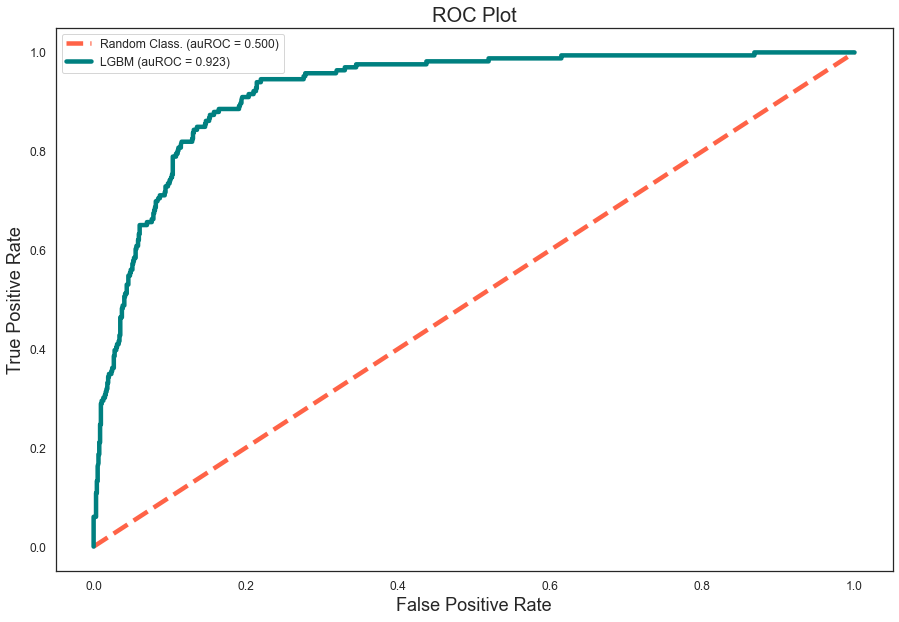

In [140]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))

'''
TPR: sensitivity
FPR: 1 - specificity
'''
random_probs = [0 for _ in range(len(test_data['Response']))]

RAND_fpr, RAND_tpr, _   = roc_curve(test_data['Response'], random_probs)

LGBM_fpr, LGBM_tpr, _   = roc_curve(test_data['Response'], class_tree.predict_proba(X_test)[:,1])



RAND_auc = 0.5

LGBM_auc = metrics_sk.roc_auc_score(test_data['Response'], class_tree.predict_proba(X_test)[:,1])



plt.plot(RAND_fpr, RAND_tpr, linestyle   = '--', label='Random Class. (auROC = %0.3f)' % RAND_auc, color = 'tomato', linewidth = 4.5)

plt.plot(LGBM_fpr, LGBM_tpr, label='LGBM (auROC = %0.3f)' % LGBM_auc, color = 'teal',linewidth = 4.5)



# Title
plt.title('ROC Plot',fontsize=20)
# Axis labels
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
# Show legend
plt.legend() # 
# Show plot
plt.show()

## Ponto de corte do resultado operacional

In [97]:
_, bins = pd.qcut(class_tree.predict_proba(X_test)[:,1], q = 10, labels = range(1, 11), retbins=True)

In [98]:
bins

array([4.83939872e-04, 2.69887185e-03, 5.78883691e-03, 1.02463668e-02,
       1.90288849e-02, 3.46227672e-02, 6.35166334e-02, 1.21180066e-01,
       2.29254197e-01, 4.91205312e-01, 9.32071277e-01])

In [99]:
bins = [-0.05, 2.69887185e-03, 5.78883691e-03, 1.02463668e-02,
       1.90288849e-02, 3.46227672e-02, 6.35166334e-02, 1.21180066e-01,
       2.29254197e-01, 4.91205312e-01, 1]

In [100]:
full_data['decil_LGBM'] = pd.cut(full_data.score_LGBM, bins, labels = range(1, 11))

In [101]:
decil_LGBM = pd.DataFrame()
decil_LGBM['event'] = full_data[full_data['Response']==1].groupby(['decil_LGBM'])['Response'].count()
decil_LGBM['not_event'] = full_data[full_data['Response']==0].groupby(['decil_LGBM'])['Response'].count()
decil_LGBM['total'] = (decil_LGBM['event']+decil_LGBM['not_event'])
decil_LGBM['event_rate'] = (decil_LGBM['event']/(decil_LGBM['event']+decil_LGBM['not_event'])).round(4)

In [133]:
decil_LGBM.reset_index(inplace = True)

In [134]:
decil_LGBM

,decil_LGBM,event,not_event,total,event_rate
0,1,0,204,204,0.0000
1,2,1,250,251,0.0040
2,3,0,225,225,0.0000
3,4,1,236,237,0.0042
4,5,2,233,235,0.0085
5,6,3,233,236,0.0127
6,7,9,211,220,0.0409
7,8,25,158,183,0.1366
8,9,65,94,159,0.4088
9,10,227,39,266,0.8534


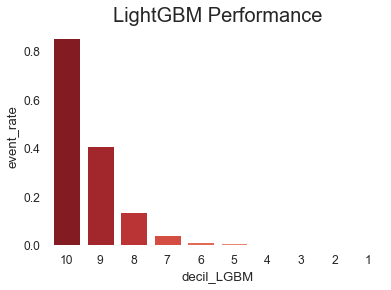

In [139]:
lgbm_plot=sns.barplot(x=decil_LGBM['decil_LGBM'],y=decil_LGBM['event_rate'], palette = 'Reds')
lgbm_plot.set_title("LightGBM Performance", fontsize = 20)
lgbm_plot.invert_xaxis()
sns.despine(left=True, bottom=True)
plt.show()

## Note que o decil mais propenso já concentra 85% de contratações

### Resultado da campanha enviando-se oferta para os clientes mais propensos do modelo (ignorando missings removidos):

In [103]:
publico_model = full_data[full_data['decil_LGBM']==10]

In [104]:
print("Receita: ", (publico_model['Z_Revenue']*publico_model['Response']).sum(),'\n')
print("Custo de contato: ", publico_model['Z_CostContact'].sum(),'\n')
print("Resultado operacional: ", (publico_model['Z_Revenue']*publico_model['Response']).sum()-publico_model['Z_CostContact'].sum())
print("Margem operacional: ", ((publico_model['Z_Revenue']*publico_model['Response']).sum()-publico_model['Z_CostContact'].sum())/(publico_model['Z_Revenue']*publico_model['Response']).sum())


Receita:  2497 

Custo de contato:  798 

Resultado operacional:  1699
Margem operacional:  0.6804164997997597


## Quadro resumo de resultados

In [105]:
results = pd.DataFrame()
results['Estratégia'] = ['base_total', 'segmentacao', 'modelo_decil_propenso']
results = results.set_index(['Estratégia'])
results['qtd_abordados'] = None
results['qtd_contratos'] = None
results['conversao'] = None
results['receita'] = None
results['custo_total'] = None
results['resultado'] = None
results['margem_operacional']=None

In [106]:
results.loc['base_total', 'qtd_abordados'] = data_seg.shape[0]
results.loc['base_total', 'qtd_contratos'] = data_seg['Response'].sum()
results.loc['base_total', 'conversao'] = (data_seg['Response'].sum()/data_seg.shape[0]).round(2)
results.loc['base_total', 'receita'] = (data_seg['Z_Revenue']*data_seg['Response']).sum()
results.loc['base_total', 'custo_total'] = data_seg['Z_CostContact'].sum()
results.loc['base_total', 'resultado'] = (data_seg['Z_Revenue']*data_seg['Response']).sum()-data_seg['Z_CostContact'].sum()
results.loc['base_total', 'margem_operacional'] = (((data_seg['Z_Revenue']*data_seg['Response']).sum()-data_seg['Z_CostContact'].sum())/(data_seg['Z_Revenue']*data_seg['Response']).sum()).round(2)

results.loc['segmentacao', 'qtd_abordados'] = publico_seg.shape[0]
results.loc['segmentacao', 'qtd_contratos'] = publico_seg['Response'].sum()
results.loc['segmentacao', 'conversao'] = (publico_seg['Response'].sum()/publico_seg.shape[0]).round(2)
results.loc['segmentacao', 'receita'] = (publico_seg['Z_Revenue']*publico_seg['Response']).sum()
results.loc['segmentacao', 'custo_total'] = publico_seg['Z_CostContact'].sum()
results.loc['segmentacao', 'resultado'] = (publico_seg['Z_Revenue']*publico_seg['Response']).sum()-publico_seg['Z_CostContact'].sum()
results.loc['segmentacao', 'margem_operacional'] = (((publico_seg['Z_Revenue']*publico_seg['Response']).sum()-publico_seg['Z_CostContact'].sum())/(publico_seg['Z_Revenue']*publico_seg['Response']).sum()).round(2)

results.loc['modelo_decil_propenso', 'qtd_abordados'] = publico_model.shape[0]
results.loc['modelo_decil_propenso', 'qtd_contratos'] = publico_model['Response'].sum()
results.loc['modelo_decil_propenso', 'conversao'] = (publico_model['Response'].sum()/publico_model.shape[0]).round(2)
results.loc['modelo_decil_propenso', 'receita'] = (publico_model['Z_Revenue']*publico_model['Response']).sum()
results.loc['modelo_decil_propenso', 'custo_total'] = publico_model['Z_CostContact'].sum()
results.loc['modelo_decil_propenso', 'resultado'] = (publico_model['Z_Revenue']*publico_model['Response']).sum()-publico_model['Z_CostContact'].sum()
results.loc['modelo_decil_propenso', 'margem_operacional'] = (((publico_model['Z_Revenue']*publico_model['Response']).sum()-publico_model['Z_CostContact'].sum())/(publico_model['Z_Revenue']*publico_model['Response']).sum()).round(2)



In [107]:
results.reset_index(inplace = True)

In [108]:
results

,Estratégia,qtd_abordados,qtd_contratos,conversao,receita,custo_total,resultado,margem_operacional
0,base_total,2216,333,0.15,3663,6648,-2985,-0.81
1,segmentacao,174,123,0.71,1353,522,831,0.61
2,modelo_decil_propenso,266,227,0.85,2497,798,1699,0.68


<AxesSubplot:title={'center':'Resultado Operacional'}, xlabel='Estratégia', ylabel='resultado'>

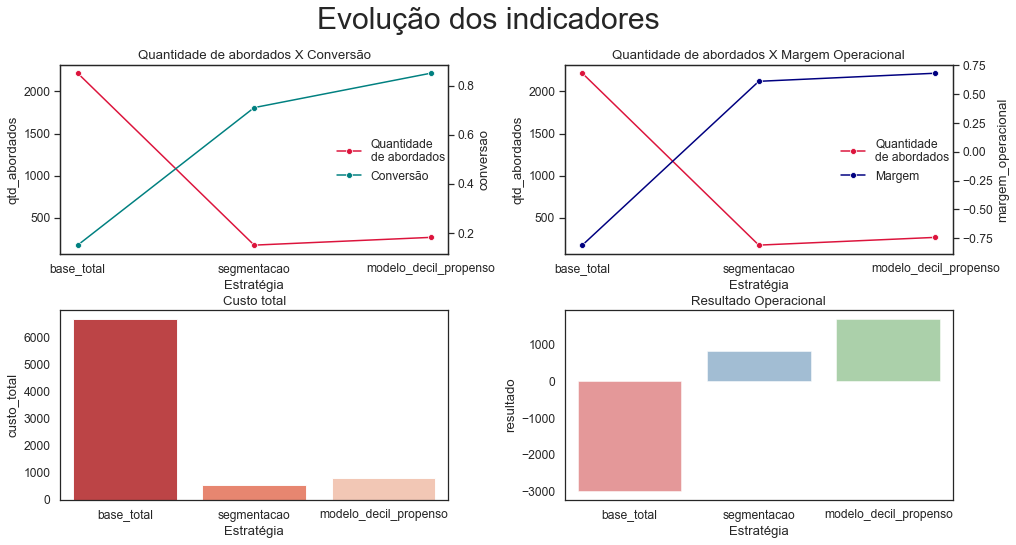

In [109]:
fig, axes = plt.subplots(2, 2, sharex=False, figsize=(16,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
plt.suptitle('Evolução dos indicadores \n', fontsize=30)

axes[0,0].set_title('Quantidade de abordados X Conversão')
#sns.barplot(ax=axes[0,0], x=results['Estratégia'], y=results['qtd_abordados'].astype(int), alpha=0.5, palette = 'Reds')
sns.lineplot(x=results['Estratégia'], y = results['qtd_abordados'].astype(float), marker='o', sort = False, ax=axes[0,0],
             label = "Quantidade\nde abordados", color = 'crimson')
ax2 = axes[0,0].twinx()
sns.lineplot(data = results['conversao'].astype(float), marker='o', sort = False, ax=ax2, color = 'teal', label = 'Conversão')
axes[0,0].legend(loc=[0.70,0.45], frameon = False)
ax2.legend(loc=[0.70,0.35], frameon = False)

axes[0,1].set_title('Quantidade de abordados X Margem Operacional')
#sns.barplot(ax=axes[0,1], x=results['Estratégia'], y=results['qtd_abordados'].astype(int), alpha=0.5, palette = 'Reds')
sns.lineplot(x=results['Estratégia'], y = results['qtd_abordados'].astype(float), marker='o', sort = False, ax=axes[0,1],
             label = "Quantidade\nde abordados",color = 'crimson')
ax2 = axes[0,1].twinx()
sns.lineplot(data = results['margem_operacional'].astype(float), marker='o', sort = False, ax=ax2, color = 'navy', label = 'Margem')
axes[0,1].legend(loc=[0.7,0.45], frameon = False)
ax2.legend(loc=[0.7,0.35], frameon = False)


axes[1,0].set_title('Custo total')
sns.barplot(ax=axes[1,0], x=results['Estratégia'], y=results['custo_total'].astype(int), alpha=0.9, palette = 'Reds_r')



axes[1,1].set_title('Resultado Operacional')
sns.barplot(ax=axes[1,1], x=results['Estratégia'], y=results['resultado'].astype(int), alpha=0.5, palette = 'Set1')



